# Model Comparisons

**Summary:**
Create models with provider level data


# Contents

- Logistic regression
  - unbalanced
  - SMOTE balanced data (includes some tuning)
- RandomForest
- XGBoost
- CatBoost
- LightGBM

- Feature importances
- SHAP values
- Confusion matrices

*Only pursued tuning for SMOTE based on modeling EDA (not included in repository)*

In [4]:
# import libraries
import matplotlib.pyplot as plt
import missingno as msno

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, average_precision_score, roc_curve
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, auc
from sklearn.metrics import precision_recall_curve

from scipy.stats import uniform, randint
import shap

# algorithms
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn import ensemble
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [6]:
# import provider level data
provider = pd.read_csv('data/provider_level_data.csv', index_col=0)
provider.head()

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,...,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,...,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,...,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.174497,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.003433,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,...,0.101449,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1


In [8]:
# import provider labels
labels = pd.read_csv('data/archive/Train-1542865627584.csv')
print(labels.shape)
labels.head(2)

(5410, 2)


,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes


In [14]:
labels[labels['PotentialFraud']=='Yes']

,Provider,PotentialFraud
1,PRV51003,Yes
3,PRV51005,Yes
13,PRV51021,Yes
25,PRV51037,Yes
37,PRV51052,Yes
...,...,...
5307,PRV57642,Yes
5324,PRV57667,Yes
5329,PRV57672,Yes
5351,PRV57697,Yes


In [16]:
# create list of fraud providers
fraud_providers = labels[labels['PotentialFraud']=='Yes']['Provider'].tolist()
fraud_providers

['PRV51003',
 'PRV51005',
 'PRV51021',
 'PRV51037',
 'PRV51052',
 'PRV51059',
 'PRV51064',
 'PRV51067',
 'PRV51077',
 'PRV51084',
 'PRV51103',
 'PRV51119',
 'PRV51126',
 'PRV51145',
 'PRV51146',
 'PRV51148',
 'PRV51149',
 'PRV51159',
 'PRV51170',
 'PRV51173',
 'PRV51178',
 'PRV51242',
 'PRV51244',
 'PRV51249',
 'PRV51263',
 'PRV51337',
 'PRV51338',
 'PRV51347',
 'PRV51357',
 'PRV51369',
 'PRV51378',
 'PRV51390',
 'PRV51393',
 'PRV51399',
 'PRV51401',
 'PRV51410',
 'PRV51421',
 'PRV51426',
 'PRV51433',
 'PRV51434',
 'PRV51447',
 'PRV51459',
 'PRV51471',
 'PRV51480',
 'PRV51482',
 'PRV51490',
 'PRV51495',
 'PRV51501',
 'PRV51507',
 'PRV51539',
 'PRV51542',
 'PRV51560',
 'PRV51567',
 'PRV51574',
 'PRV51578',
 'PRV51584',
 'PRV51586',
 'PRV51590',
 'PRV51593',
 'PRV51604',
 'PRV51614',
 'PRV51805',
 'PRV51818',
 'PRV51826',
 'PRV51836',
 'PRV51840',
 'PRV51842',
 'PRV51851',
 'PRV51857',
 'PRV51868',
 'PRV51873',
 'PRV51876',
 'PRV51920',
 'PRV51940',
 'PRV51948',
 'PRV51951',
 'PRV51979',

In [18]:
# add labels to provider data
provider['fraud_suspected'] = [
    1 if provider in fraud_providers else 0 for provider in provider['Provider'] 
]
provider.head()

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,...,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,...,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,...,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,PRV51004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,PRV51005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,...,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0


In [20]:
# import raw data for reference
inpatient_raw = pd.read_csv('data/archive/Train_Inpatientdata-1542865627584.csv')
outpatient_raw = pd.read_csv('data/archive/Train_Outpatientdata-1542865627584.csv')
beneficiary_raw = pd.read_csv('data/archive/Train_Beneficiarydata-1542865627584.csv')

# Logistic Regression

create a separate dataset appropriate for logistic regression model with the following:
- NaN values imputed with 0
- apply scaling

In [27]:
# impute missing values with zeros
provider_lr = provider.copy()
provider_lr = provider_lr.fillna(0)
provider_lr.head()

,Provider,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,...,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,PRV51001,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.000000,5.385165,5.000000,...,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,PRV51003,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.161290,4.447116,5.161290,...,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1
2,PRV51004,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.926174,23.0,34.0,12.416667,2.583893,0.0,52170.0,0,1,0
3,PRV51005,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.424893,45.0,95.0,97.083333,2.588841,0.0,280910.0,0,1,1
4,PRV51007,1068.0,6333.333333,3511.884584,3.0,77.666667,4.509250,5.333333,1.527525,5.333333,...,0.811594,11.0,13.0,5.750000,2.797101,0.0,14710.0,1,1,0


In [29]:
provider_lr.isnull().sum().sum()

0

In [31]:
# drop target
provider_lr = provider_lr.drop(columns=['Provider'], axis=1)
provider_lr.head(2)

,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,...,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice,fraud_suspected
0,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.00000,5.385165,5.00000,5.385165,...,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1,0
1,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.16129,4.447116,5.16129,4.447116,...,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1,1


In [33]:
# define NaN handled features for logistic regression
X_lr = provider_lr.drop(columns=['fraud_suspected'])
y = provider_lr['fraud_suspected']

In [35]:
X_lr.head(2)

,deductible_mean_ip,reimbursement_mean_ip,reimbursement_std_ip,DiagnosisGroupCode_nunique_ip,age_mean_ip,age_std_ip,inpatient_duration_mean_ip,inpatient_duration_std_ip,claim_duration_mean_ip,claim_duration_std_ip,...,other_ratio_op,patient_ratio_op,num_state_op,num_county_op,claim_freq_op,mean_diagnosis_billed_op,mean_procedures_billed_op,total_reimbursement_op,inpatient_practice,outpatient_practice
0,1068.0,19400.000000,18352.111595,5.0,77.600000,10.430724,5.00000,5.385165,5.00000,5.385165,...,0.350000,0.950000,5.0,5.0,1.666667,2.200000,0.0,7640.0,1,1
1,1068.0,9241.935484,8513.606244,58.0,69.903226,14.354653,5.16129,4.447116,5.16129,4.447116,...,0.314286,0.942857,18.0,22.0,5.833333,2.714286,0.0,32670.0,1,1


In [37]:
# scale the data before splitting - required for logistic regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lr)

In [39]:
# split the scaled data
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [41]:
print(X_scaled.shape, X_train_lr.shape, X_test_lr.shape)

(5410, 59) (4328, 59) (1082, 59)


## Logistic regression on unbalanced data

In [46]:
lr_unbalanced = LogisticRegression()

# train model on unbalanced, NaN handled training data
lr_unbalanced.fit(X_train_lr, y_train_lr)

# make predictions using NaN handled test data
y_pred_unbalanced = lr_unbalanced.predict(X_test_lr)

print('UNBALANCED LOGISTIC REGRESSION')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test_lr, y_pred_unbalanced))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test_lr, y_pred_unbalanced))

UNBALANCED LOGISTIC REGRESSION
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       981
           1       0.76      0.59      0.67       101

    accuracy                           0.94      1082
   macro avg       0.86      0.79      0.82      1082
weighted avg       0.94      0.94      0.94      1082

CONFUSION MATRIX:
[[962  19]
 [ 41  60]]


In [48]:
# generate probability predictions
y_probs_unbalanced = lr_unbalanced.predict_proba(X_test_lr)[:, 1]

In [50]:
# calculate ROC curve components
fpr_unbalanced, tpr_unbalanced, thresholds_unbalanced = roc_curve(y_test_lr, y_probs_unbalanced)

In [52]:
# generate AUC score
roc_auc_unbalanced = roc_auc_score(y_test_lr, y_probs_unbalanced)

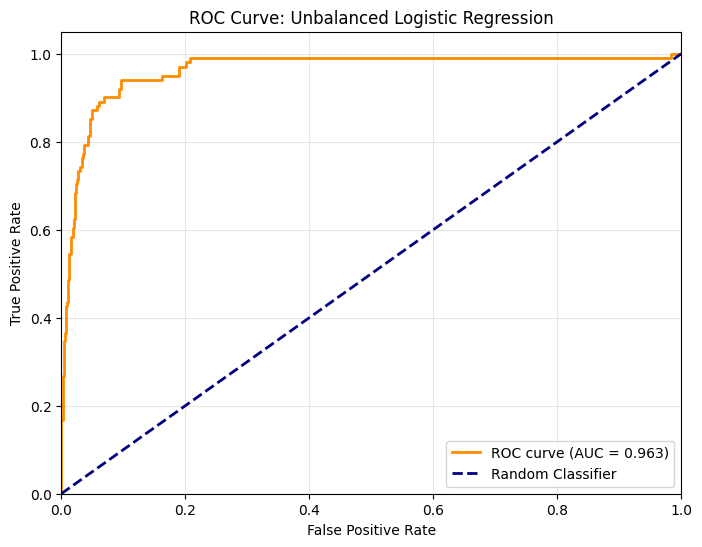

In [54]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_unbalanced, tpr_unbalanced, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_unbalanced:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Unbalanced Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [57]:
# calculate precision-recall curve components (NOTE: _pr notation)
precision_unbalanced, recall_unbalanced, thresholds_pr = precision_recall_curve(y_test_lr, y_probs_unbalanced)

In [59]:
# generate PR_AUC score
pr_auc_unbalanced = auc(recall_unbalanced, precision_unbalanced)

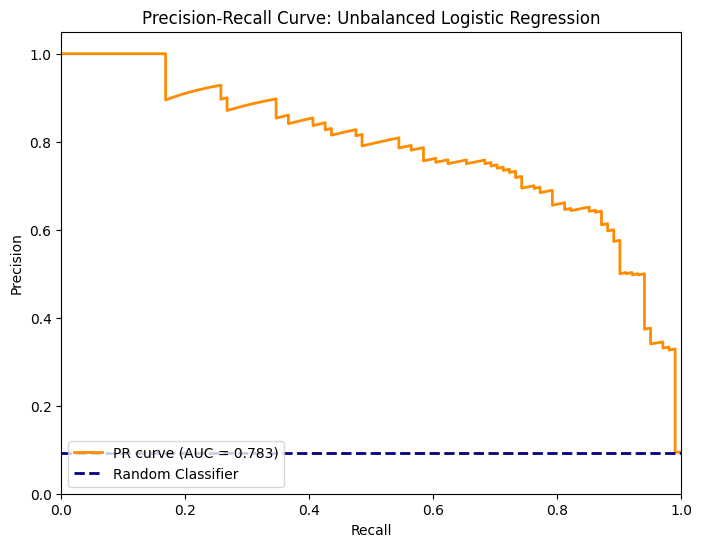

In [61]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_unbalanced, precision_unbalanced, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_unbalanced:.3f})')
plt.axhline(y=y_test_lr.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: Unbalanced Logistic Regression')
plt.legend(loc="lower left")

## Logistic regression on SMOTE balanced data

In [65]:
# number of classes in training set before smote
y_train_lr.value_counts()

fraud_suspected
0    3923
1     405
Name: count, dtype: int64

In [67]:
sm = SMOTE(random_state=42)

In [69]:
# apply SMOTE to scaled training set
X_train_smote, y_train_smote = sm.fit_resample(X_train_lr, y_train_lr)

In [71]:
# number of classes in training set after SMOTE application
y_train_smote.value_counts()

fraud_suspected
0    3923
1    3923
Name: count, dtype: int64

In [73]:
lr_smote = LogisticRegression(max_iter=1000)

# train model on SMOTE balanced, NaN handled training data
lr_smote.fit(X_train_smote, y_train_smote)

# make predictions using NaN handled, UNbalanced test data (real world, unbalanced data)
y_pred_smote = lr_smote.predict(X_test_lr)

print('SMOTE BALANCED LOGISTIC REGRESSION')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test_lr, y_pred_smote))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test_lr, y_pred_smote))

SMOTE BALANCED LOGISTIC REGRESSION
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       981
           1       0.47      0.93      0.62       101

    accuracy                           0.90      1082
   macro avg       0.73      0.91      0.78      1082
weighted avg       0.94      0.90      0.91      1082

CONFUSION MATRIX:
[[875 106]
 [  7  94]]


In [75]:
# generate probability predictions
y_probs_smote = lr_smote.predict_proba(X_test_lr)[:, 1]

In [77]:
# calculate ROC curve components
fpr_smote, tpr_smote, thresholds_smote = roc_curve(y_test_lr, y_probs_smote)

In [79]:
# generate AUC score
roc_auc_smote = roc_auc_score(y_test_lr, y_probs_smote)

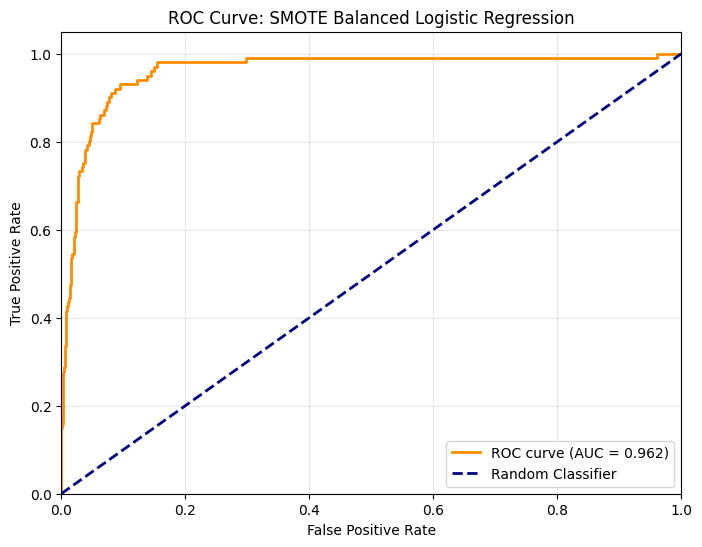

In [81]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_smote, tpr_smote, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_smote:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: SMOTE Balanced Logistic Regression')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [84]:
# calculate precision-recall curve components
precision_smote, recall_smote, thresholds_smote = precision_recall_curve(y_test_lr, y_probs_smote)

In [86]:
# generate PR_AUC score
pr_auc_smote = auc(recall_smote, precision_smote)

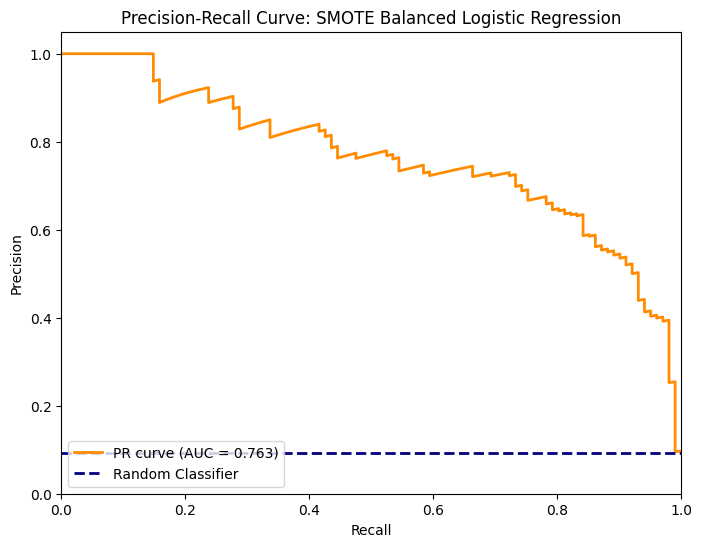

In [88]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_smote, precision_smote, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_smote:.3f})')
plt.axhline(y=y_test_lr.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: SMOTE Balanced Logistic Regression')
plt.legend(loc="lower left")

## Compare both logistic regression models

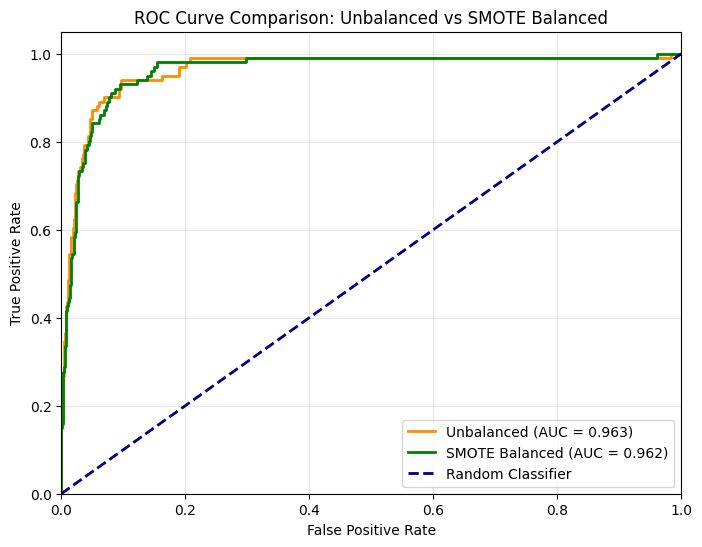

In [99]:
# visualize both ROC curves on one plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_unbalanced, tpr_unbalanced, color='darkorange', lw=2, 
         label=f'Unbalanced (AUC = {roc_auc_unbalanced:.3f})')
plt.plot(fpr_smote, tpr_smote, color='green', lw=2, 
         label=f'SMOTE Balanced (AUC = {roc_auc_smote:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Unbalanced vs SMOTE Balanced')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

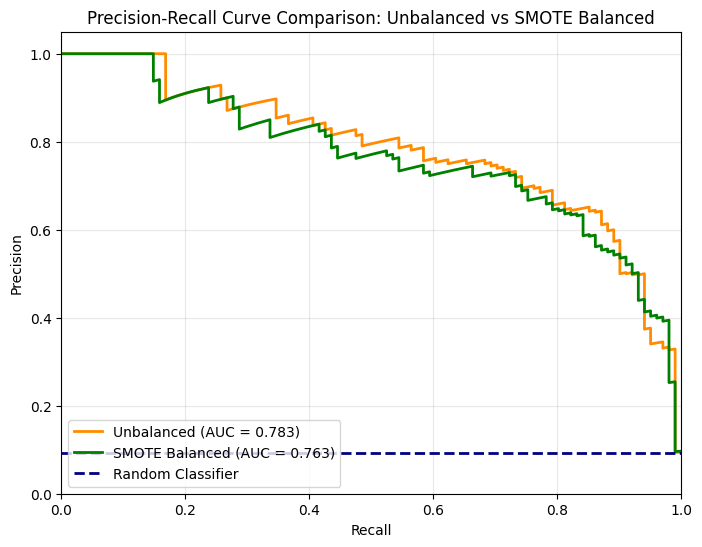

In [101]:
# visualize both precision-recall curves on one plot
plt.figure(figsize=(8, 6))
plt.plot(recall_unbalanced, precision_unbalanced, color='darkorange', lw=2, 
         label=f'Unbalanced (AUC = {pr_auc_unbalanced:.3f})')
plt.plot(recall_smote, precision_smote, color='green', lw=2, 
         label=f'SMOTE Balanced (AUC = {pr_auc_smote:.3f})')
plt.axhline(y=y_test_lr.mean(), color='navy', lw=2, linestyle='--', 
            label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: Unbalanced vs SMOTE Balanced')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

# Tuning

https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html

In [107]:
# split the scaled data
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=21
)
# apply SMOTE to scaled training set
X_train_smote, y_train_smote = sm.fit_resample(X_train_lr, y_train_lr)

### SMOTE
- where cost of fps and fns are the same
- when they differ by an order of magnitude

In [110]:
# define labels
pos_label, neg_label = 1, 0

In [112]:
# create scorer for false positive rate FPR 
def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp) # calculate specificity
    return 1 - tnr 

In [114]:
from sklearn.metrics import make_scorer, precision_score, recall_score

tpr_score = recall_score  # TPR and recall are the same metric
scoring = {
    "precision": make_scorer(precision_score, pos_label=pos_label),
    "recall": make_scorer(recall_score, pos_label=pos_label),
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(tpr_score, pos_label=pos_label),
}

In [118]:
# create cost-sensitive scoring function for minimizing total cost (maximizing gain)

# where the cost of fps and fns are the same
def credit_gain_score_equal(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    print(cm)
    gain_matrix = np.array(
        [
            [0, -1], # -1 gain for false positives
            [-1, 0], # -1 gain for false negatives
        ]
    )
    # calculate corresponding cost and return sum
    return np.sum(cm * gain_matrix)

def credit_gain_score_unequal(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    print(cm)
    gain_matrix = np.array(
        [
            [0, -1], # -1 gain for false positives
            [-10, 0], # -1 gain for false negatives
        ]
    )
    # calculate corresponding cost and return sum
    return np.sum(cm * gain_matrix)


scoring["credit_gain_equal"] = make_scorer(
    credit_gain_score_equal, neg_label=neg_label, pos_label=pos_label
)
scoring["credit_gain_unequal"] = make_scorer(
    credit_gain_score_unequal, neg_label=neg_label, pos_label=pos_label
)

In [121]:
# use smote model
lr_smote = LogisticRegression(max_iter=1000).fit(X_train_smote, y_train_smote)
lr_smote

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

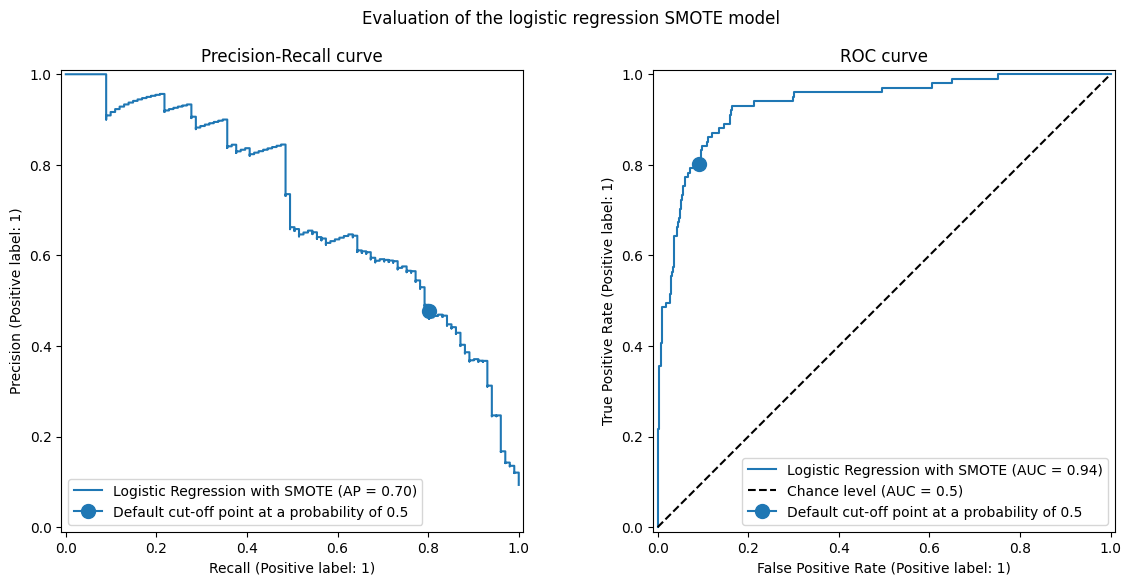

In [124]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    lr_smote, X_test_lr, y_test_lr, pos_label=pos_label, ax=axs[0], name="Logistic Regression with SMOTE"
)
axs[0].plot(
    scoring["recall"](lr_smote, X_test_lr, y_test_lr),
    scoring["precision"](lr_smote, X_test_lr, y_test_lr),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    lr_smote,
    X_test_lr,
    y_test_lr,
    pos_label=pos_label,
    ax=axs[1],
    name="Logistic Regression with SMOTE",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](lr_smote, X_test_lr, y_test_lr),
    scoring["tpr"](lr_smote, X_test_lr, y_test_lr),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the logistic regression SMOTE model")

In [126]:
# compute value of business metric for all mistakes being equal
print(f"Business defined metric: {scoring['credit_gain_equal'](lr_smote, X_test_lr, y_test_lr)}")

[[892  89]
 [ 20  81]]
Business defined metric: -109


In [128]:
# compute value of business metric for mistakes differing by order of magnitude
print(f"Business defined metric: {scoring['credit_gain_unequal'](lr_smote, X_test_lr, y_test_lr)}")

[[892  89]
 [ 20  81]]
Business defined metric: -289


In [130]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_smote_model_unequal = TunedThresholdClassifierCV(
    estimator=lr_smote,
    scoring=scoring["credit_gain_unequal"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_smote_model_equal = TunedThresholdClassifierCV(
    estimator=lr_smote,
    scoring=scoring["credit_gain_equal"],
    store_cv_results=True,  # necessary to inspect all results
)
# fit with SMOTE balanced data
tuned_smote_model_equal.fit(X_train_smote, y_train_smote) 
tuned_smote_model_unequal.fit(X_train_smote, y_train_smote) 
print(f"mistakes being equal: {tuned_smote_model_equal.best_threshold_=:0.2f}")
print(f"mistakes different by order of magnitude: {tuned_smote_model_unequal.best_threshold_=:0.2f}")

[[  0 785]
 [  0 785]]
[[148 637]
 [  1 784]]
[[255 530]
 [  1 784]]
[[321 464]
 [  3 782]]
[[371 414]
 [  5 780]]
[[409 376]
 [  6 779]]
[[451 334]
 [  9 776]]
[[473 312]
 [ 10 775]]
[[504 281]
 [ 12 773]]
[[522 263]
 [ 12 773]]
[[543 242]
 [ 16 769]]
[[559 226]
 [ 17 768]]
[[575 210]
 [ 21 764]]
[[585 200]
 [ 24 761]]
[[596 189]
 [ 25 760]]
[[604 181]
 [ 26 759]]
[[610 175]
 [ 26 759]]
[[617 168]
 [ 27 758]]
[[628 157]
 [ 30 755]]
[[631 154]
 [ 33 752]]
[[638 147]
 [ 33 752]]
[[641 144]
 [ 34 751]]
[[648 137]
 [ 34 751]]
[[652 133]
 [ 35 750]]
[[656 129]
 [ 36 749]]
[[658 127]
 [ 36 749]]
[[662 123]
 [ 38 747]]
[[667 118]
 [ 39 746]]
[[672 113]
 [ 39 746]]
[[674 111]
 [ 41 744]]
[[678 107]
 [ 42 743]]
[[679 106]
 [ 42 743]]
[[684 101]
 [ 44 741]]
[[689  96]
 [ 47 738]]
[[690  95]
 [ 49 736]]
[[691  94]
 [ 51 734]]
[[694  91]
 [ 54 731]]
[[696  89]
 [ 55 730]]
[[701  84]
 [ 58 727]]
[[703  82]
 [ 60 725]]
[[704  81]
 [ 62 723]]
[[706  79]
 [ 66 719]]
[[708  77]
 [ 71 714]]
[[712  73]


In [134]:
def plot_smote_roc_pr_curves(default_model, tuned_model, *, title):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))

    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = ("Default SMOTE", "Tuned SMOTE")
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((default_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test_lr,
            y_test_lr,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test_lr, y_test_lr),
            scoring["precision"](est, X_test_lr, y_test_lr),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        RocCurveDisplay.from_estimator(
            est,
            X_test_lr,
            y_test_lr,
            pos_label=pos_label,
            curve_kwargs=dict(linestyle=linestyle, color=color),
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test_lr, y_test_lr),
            scoring["tpr"](est, X_test_lr, y_test_lr),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )

    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()

    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

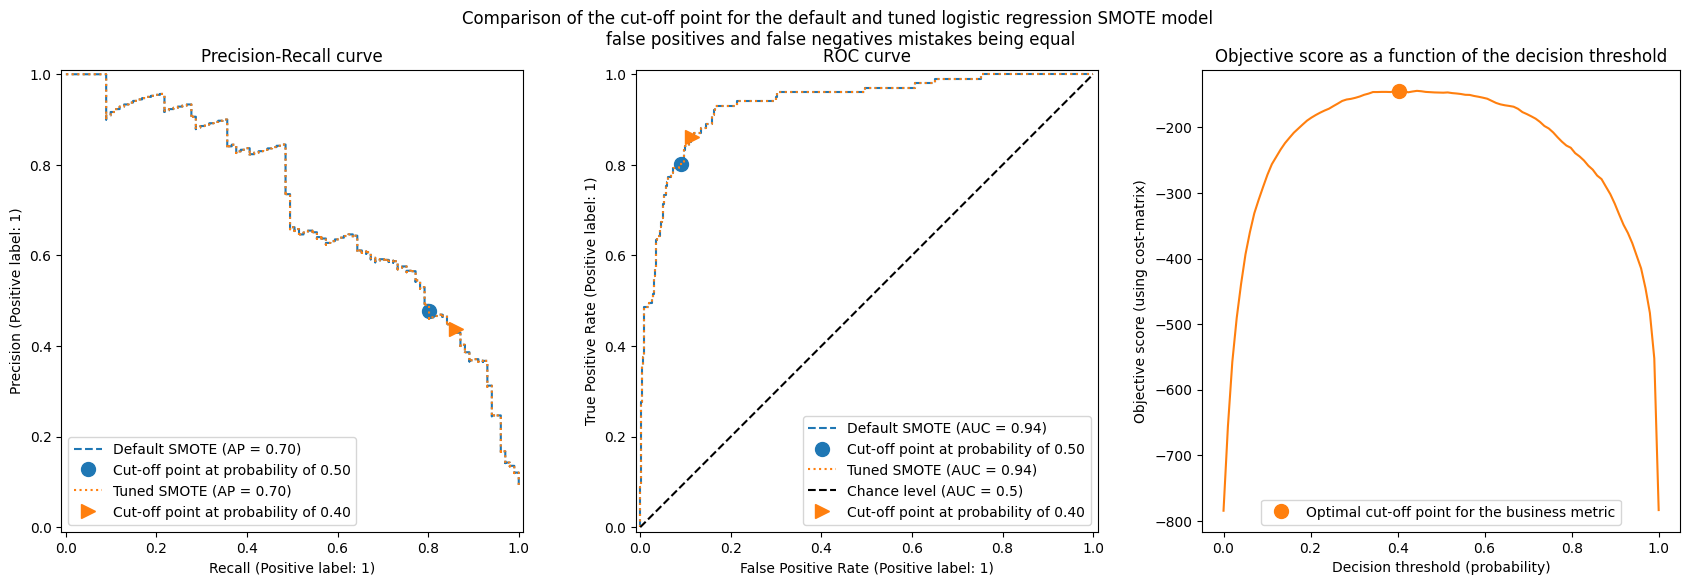

In [136]:
title = "Comparison of the cut-off point for the default and tuned logistic regression SMOTE model \nfalse positives and false negatives mistakes being equal"
plot_smote_roc_pr_curves(lr_smote, tuned_smote_model_equal, title=title)

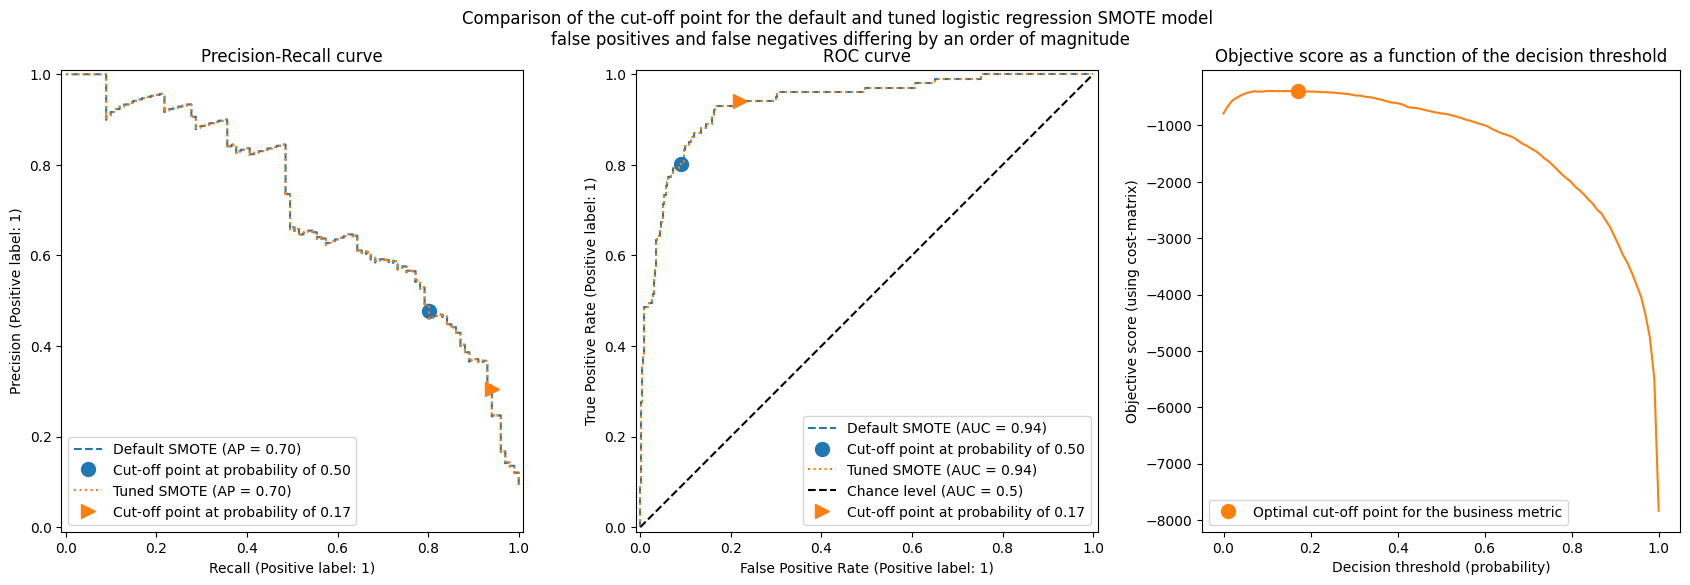

In [137]:
title = "Comparison of the cut-off point for the default and tuned logistic regression SMOTE model \nfalse positives and false negatives differing by an order of magnitude"
plot_smote_roc_pr_curves(lr_smote, tuned_smote_model_unequal, title=title)

In [140]:
print(f"Business defined metric: {scoring['credit_gain_equal'](tuned_smote_model_equal, X_test_lr, y_test_lr)}")

[[869 112]
 [ 14  87]]
Business defined metric: -126


In [142]:
print(f"Business defined metric: {scoring['credit_gain_unequal'](tuned_smote_model_unequal, X_train_smote, y_train_smote)}")

[[3027  896]
 [ 100 3823]]
Business defined metric: -1896


In [144]:
tuned_smote_model_equal.best_score_

-144.00000083825188

In [146]:
tuned_smote_model_unequal.best_score_

-383.60044940679853

[[964  17]
 [ 46  55]]
Unbalanced LR baseline cost, all mistakes being equal: -63
[[964  17]
 [ 46  55]]
Unbalanced LR baseline cost, mistakes differing by order of magnitude: -477


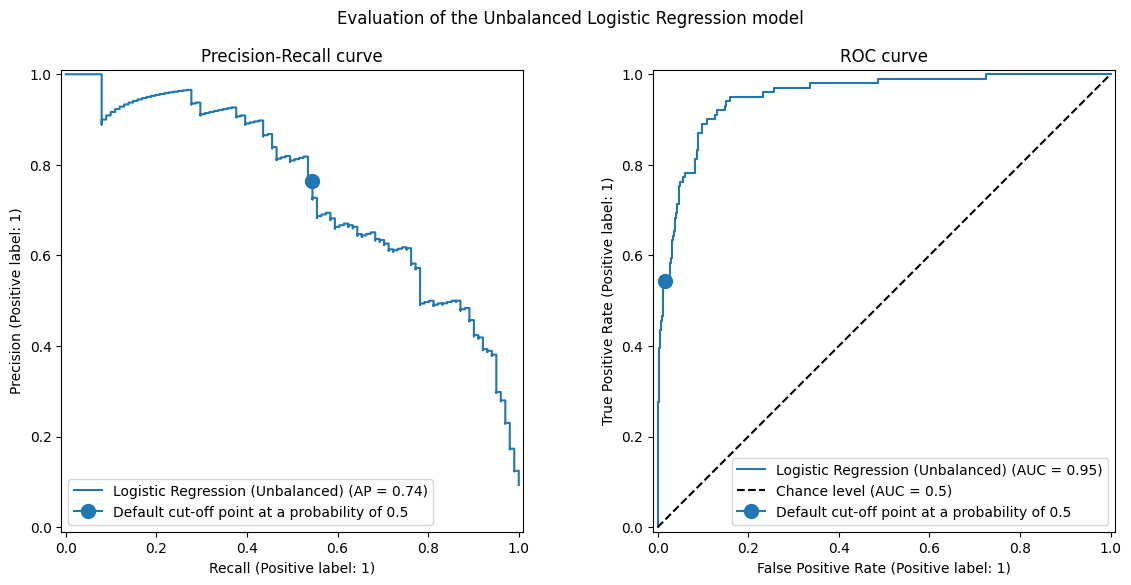

In [153]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

PrecisionRecallDisplay.from_estimator(
    lr_unbalanced, X_test_lr, y_test_lr, pos_label=pos_label, ax=axs[0], name="Logistic Regression (Unbalanced)"
)
axs[0].plot(
    scoring["recall"](lr_unbalanced, X_test_lr, y_test_lr),
    scoring["precision"](lr_unbalanced, X_test_lr, y_test_lr),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[0].set_title("Precision-Recall curve")
axs[0].legend()

RocCurveDisplay.from_estimator(
    lr_unbalanced,
    X_test_lr,
    y_test_lr,
    pos_label=pos_label,
    ax=axs[1],
    name="Logistic Regression (Unbalanced)",
    plot_chance_level=True,
)
axs[1].plot(
    scoring["fpr"](lr_unbalanced, X_test_lr, y_test_lr),
    scoring["tpr"](lr_unbalanced, X_test_lr, y_test_lr),
    marker="o",
    markersize=10,
    color="tab:blue",
    label="Default cut-off point at a probability of 0.5",
)
axs[1].set_title("ROC curve")
axs[1].legend()
_ = fig.suptitle("Evaluation of the Unbalanced Logistic Regression model")

# Print baseline performance
print(f"Unbalanced LR baseline cost, all mistakes being equal: {scoring['credit_gain_equal'](lr_unbalanced, X_test_lr, y_test_lr)}")
print(f"Unbalanced LR baseline cost, mistakes differing by order of magnitude: {scoring['credit_gain_unequal'](lr_unbalanced, X_test_lr, y_test_lr)}")

In [155]:
from sklearn.model_selection import TunedThresholdClassifierCV

tuned_unbalanced_equal = TunedThresholdClassifierCV(
    estimator=lr_unbalanced,
    scoring=scoring["credit_gain_equal"],
    store_cv_results=True,
)

tuned_unbalanced_unequal = TunedThresholdClassifierCV(
    estimator=lr_unbalanced,
    scoring=scoring["credit_gain_unequal"],
    store_cv_results=True,
)

# Fit on unbalanced training data
tuned_unbalanced_equal.fit(X_train_lr, y_train_lr)
print(f"{tuned_unbalanced_equal.best_threshold_=:.2f}")

[[  0 785]
 [  0  81]]
[[396 389]
 [  1  80]]
[[568 217]
 [  2  79]]
[[627 158]
 [  3  78]]
[[654 131]
 [  4  77]]
[[666 119]
 [  6  75]]
[[681 104]
 [  6  75]]
[[688  97]
 [  6  75]]
[[695  90]
 [  6  75]]
[[704  81]
 [  7  74]]
[[709  76]
 [  7  74]]
[[716  69]
 [  7  74]]
[[723  62]
 [  8  73]]
[[730  55]
 [ 11  70]]
[[734  51]
 [ 11  70]]
[[739  46]
 [ 13  68]]
[[740  45]
 [ 13  68]]
[[741  44]
 [ 13  68]]
[[743  42]
 [ 15  66]]
[[744  41]
 [ 16  65]]
[[746  39]
 [ 18  63]]
[[747  38]
 [ 19  62]]
[[748  37]
 [ 20  61]]
[[749  36]
 [ 21  60]]
[[751  34]
 [ 21  60]]
[[752  33]
 [ 22  59]]
[[755  30]
 [ 22  59]]
[[757  28]
 [ 24  57]]
[[758  27]
 [ 25  56]]
[[758  27]
 [ 26  55]]
[[760  25]
 [ 27  54]]
[[761  24]
 [ 27  54]]
[[761  24]
 [ 27  54]]
[[763  22]
 [ 29  52]]
[[763  22]
 [ 29  52]]
[[765  20]
 [ 29  52]]
[[766  19]
 [ 30  51]]
[[766  19]
 [ 31  50]]
[[766  19]
 [ 31  50]]
[[767  18]
 [ 32  49]]
[[767  18]
 [ 35  46]]
[[767  18]
 [ 36  45]]
[[770  15]
 [ 38  43]]
[[770  15]


In [157]:
tuned_unbalanced_unequal.fit(X_train_lr, y_train_lr)
print(f"{tuned_unbalanced_unequal.best_threshold_=:.2f}")

[[  0 785]
 [  0  81]]
[[396 389]
 [  1  80]]
[[568 217]
 [  2  79]]
[[627 158]
 [  3  78]]
[[654 131]
 [  4  77]]
[[666 119]
 [  6  75]]
[[681 104]
 [  6  75]]
[[688  97]
 [  6  75]]
[[695  90]
 [  6  75]]
[[704  81]
 [  7  74]]
[[709  76]
 [  7  74]]
[[716  69]
 [  7  74]]
[[723  62]
 [  8  73]]
[[730  55]
 [ 11  70]]
[[734  51]
 [ 11  70]]
[[739  46]
 [ 13  68]]
[[740  45]
 [ 13  68]]
[[741  44]
 [ 13  68]]
[[743  42]
 [ 15  66]]
[[744  41]
 [ 16  65]]
[[746  39]
 [ 18  63]]
[[747  38]
 [ 19  62]]
[[748  37]
 [ 20  61]]
[[749  36]
 [ 21  60]]
[[751  34]
 [ 21  60]]
[[752  33]
 [ 22  59]]
[[755  30]
 [ 22  59]]
[[757  28]
 [ 24  57]]
[[758  27]
 [ 25  56]]
[[758  27]
 [ 26  55]]
[[760  25]
 [ 27  54]]
[[761  24]
 [ 27  54]]
[[761  24]
 [ 27  54]]
[[763  22]
 [ 29  52]]
[[763  22]
 [ 29  52]]
[[765  20]
 [ 29  52]]
[[766  19]
 [ 30  51]]
[[766  19]
 [ 31  50]]
[[766  19]
 [ 31  50]]
[[767  18]
 [ 32  49]]
[[767  18]
 [ 35  46]]
[[767  18]
 [ 36  45]]
[[770  15]
 [ 38  43]]
[[770  15]


In [158]:
def plot_roc_pr_curves(default_model, tuned_model, *, title, default_name="Default", tuned_name="Tuned"):
    """
    Plot ROC and Precision-Recall curves comparing default and tuned models.
    
    Parameters:
    -----------
    default_model : estimator
        The baseline model with default threshold (0.5)
    tuned_model : TunedThresholdClassifierCV
        The model with optimized threshold
    title : str
        Overall title for the figure
    default_name : str, optional
        Name for the default model in legend (default: "Default")
    tuned_name : str, optional
        Name for the tuned model in legend (default: "Tuned")
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(21, 6))
    linestyles = ("dashed", "dotted")
    markerstyles = ("o", ">")
    colors = ("tab:blue", "tab:orange")
    names = (default_name, tuned_name)
    
    for idx, (est, linestyle, marker, color, name) in enumerate(
        zip((default_model, tuned_model), linestyles, markerstyles, colors, names)
    ):
        decision_threshold = getattr(est, "best_threshold_", 0.5)
        
        # Precision-Recall curve
        PrecisionRecallDisplay.from_estimator(
            est,
            X_test_lr,
            y_test_lr,
            pos_label=pos_label,
            linestyle=linestyle,
            color=color,
            ax=axs[0],
            name=name,
        )
        axs[0].plot(
            scoring["recall"](est, X_test_lr, y_test_lr),
            scoring["precision"](est, X_test_lr, y_test_lr),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
        
        # ROC curve
        RocCurveDisplay.from_estimator(
            est,
            X_test_lr,
            y_test_lr,
            pos_label=pos_label,
            curve_kwargs=dict(linestyle=linestyle, color=color),
            ax=axs[1],
            name=name,
            plot_chance_level=idx == 1,
        )
        axs[1].plot(
            scoring["fpr"](est, X_test_lr, y_test_lr),
            scoring["tpr"](est, X_test_lr, y_test_lr),
            marker,
            markersize=10,
            color=color,
            label=f"Cut-off point at probability of {decision_threshold:.2f}",
        )
    
    axs[0].set_title("Precision-Recall curve")
    axs[0].legend()
    axs[1].set_title("ROC curve")
    axs[1].legend()
    
    # Threshold optimization curve (only for tuned model)
    axs[2].plot(
        tuned_model.cv_results_["thresholds"],
        tuned_model.cv_results_["scores"],
        color="tab:orange",
    )
    axs[2].plot(
        tuned_model.best_threshold_,
        tuned_model.best_score_,
        "o",
        markersize=10,
        color="tab:orange",
        label="Optimal cut-off point for the business metric",
    )
    axs[2].legend()
    axs[2].set_xlabel("Decision threshold (probability)")
    axs[2].set_ylabel("Objective score (using cost-matrix)")
    axs[2].set_title("Objective score as a function of the decision threshold")
    fig.suptitle(title)

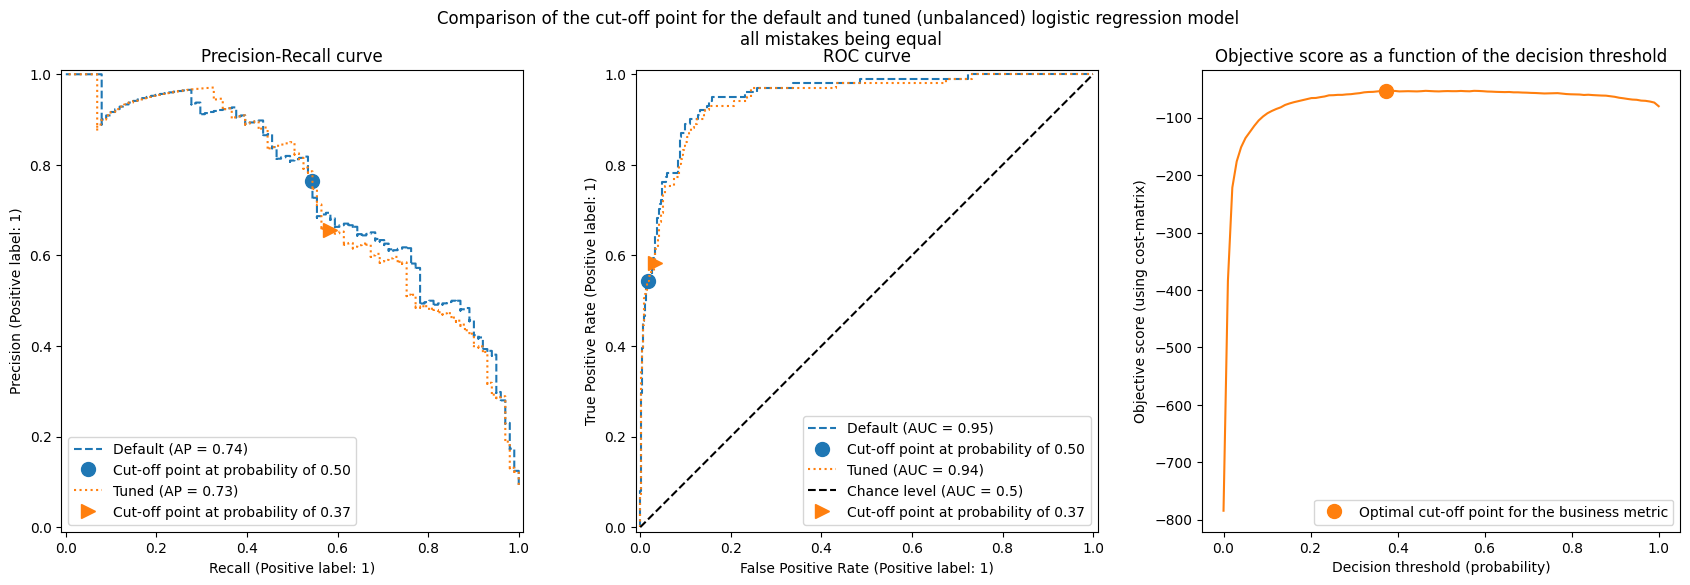

In [161]:
title = "Comparison of the cut-off point for the default and tuned (unbalanced) logistic regression model \nall mistakes being equal"
plot_roc_pr_curves(lr_unbalanced, tuned_unbalanced_equal, title=title)

In [162]:
print(f"Business defined metric: {scoring['credit_gain_equal'](tuned_unbalanced_equal, X_test_lr, y_test_lr)}")

[[950  31]
 [ 42  59]]
Business defined metric: -73


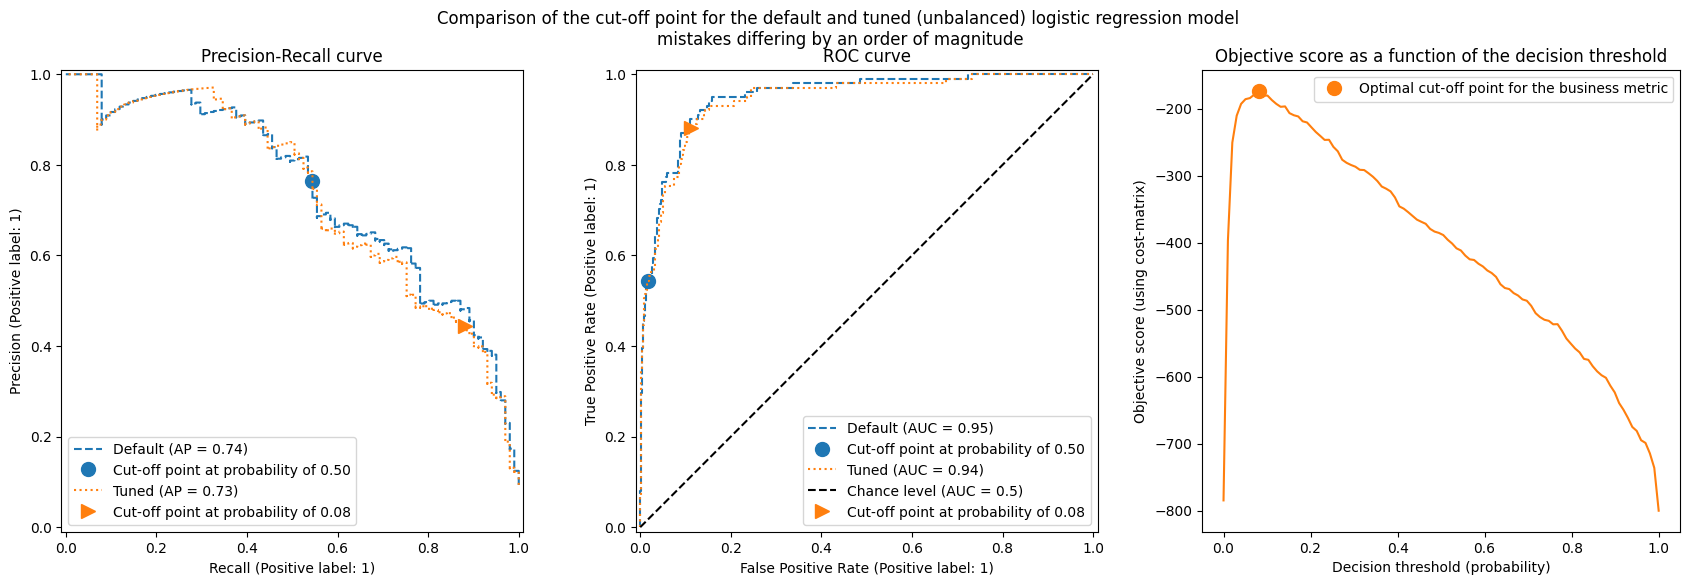

In [165]:
title = "Comparison of the cut-off point for the default and tuned (unbalanced) logistic regression model \nmistakes differing by an order of magnitude"
plot_roc_pr_curves(lr_unbalanced, tuned_unbalanced_unequal, title=title)

In [167]:
print(f"Business defined metric: {scoring['credit_gain_unequal'](tuned_unbalanced_unequal, X_test_lr, y_test_lr)}")

[[870 111]
 [ 12  89]]
Business defined metric: -231


# Black Box Models
- RandomForest
- LightGBM
- XGBoost
- CatBoost

No need to handle NaNs or scale data for these models. Use on provider data as is.

Consider balancing parameters for each model.

In [207]:
# define features for black box models 
X = provider.drop(columns=['fraud_suspected', 'Provider'])
y = provider['fraud_suspected']

In [209]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Random forest

In [213]:
# active native balancing
rf = ensemble.RandomForestClassifier(class_weight='balanced', random_state=42)

# train model
rf.fit(X_train, y_train)

# make predictions on test data
y_pred_rf = rf.predict(X_test)

print('RANDOMFOREST')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred_rf))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_rf))

RANDOMFOREST
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       981
           1       0.85      0.52      0.65       101

    accuracy                           0.95      1082
   macro avg       0.90      0.76      0.81      1082
weighted avg       0.94      0.95      0.94      1082

CONFUSION MATRIX:
[[972   9]
 [ 48  53]]


In [216]:
# generate probability predictions
y_probs_rf = rf.predict_proba(X_test)[:, 1]

In [218]:
# calculate ROC curve components
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_probs_rf)

In [220]:
# generate AUC score
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

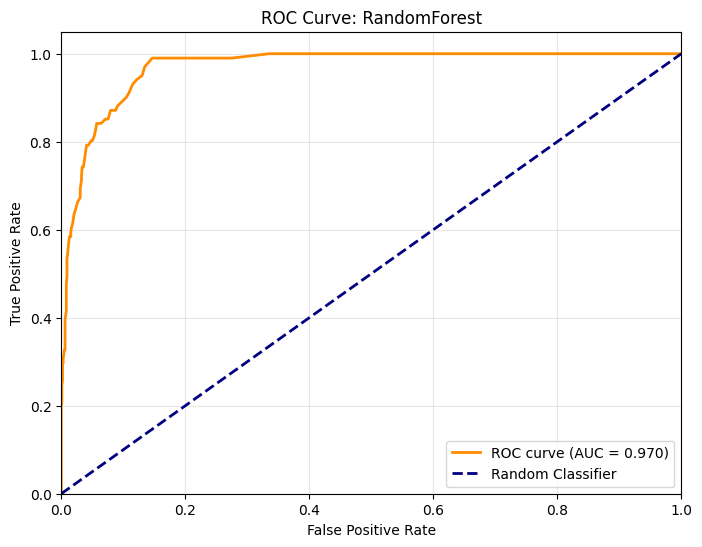

In [222]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_rf:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: RandomForest')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [225]:
# calculate precision-recall curve components (NOTE: _pr notation)
precision_rf, recall_rf, thresholds_lgmb_pr = precision_recall_curve(y_test, y_probs_rf)

In [227]:
# generate PR_AUC score
pr_auc_rf = auc(recall_rf, precision_rf)

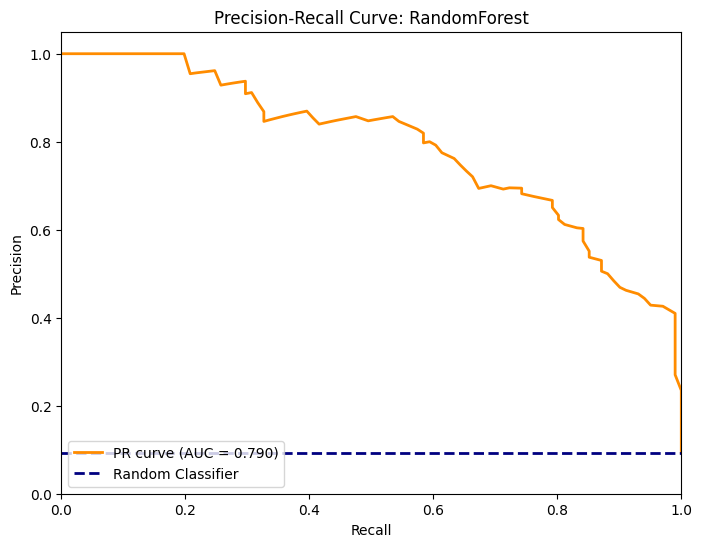

In [229]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_rf, precision_rf, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_rf:.3f})')
plt.axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: RandomForest')
plt.legend(loc="lower left")

## LightGBM

In [232]:
# active native balancing
lgbm = lgb.LGBMClassifier(is_unbalance=True, verbose=-1, random_state=42)

# train model
lgbm.fit(X_train, y_train)

# make predictions on test data
y_pred_lgbm = lgbm.predict(X_test)

print('LIGHTGBM')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred_lgbm))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_lgbm))

LIGHTGBM
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       981
           1       0.70      0.75      0.73       101

    accuracy                           0.95      1082
   macro avg       0.84      0.86      0.85      1082
weighted avg       0.95      0.95      0.95      1082

CONFUSION MATRIX:
[[949  32]
 [ 25  76]]


In [234]:
# generate probability predictions
y_probs_lgbm = lgbm.predict_proba(X_test)[:, 1]

In [236]:
# calculate ROC curve components
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_probs_lgbm)

In [238]:
# generate AUC score
roc_auc_lgbm = roc_auc_score(y_test, y_probs_lgbm)

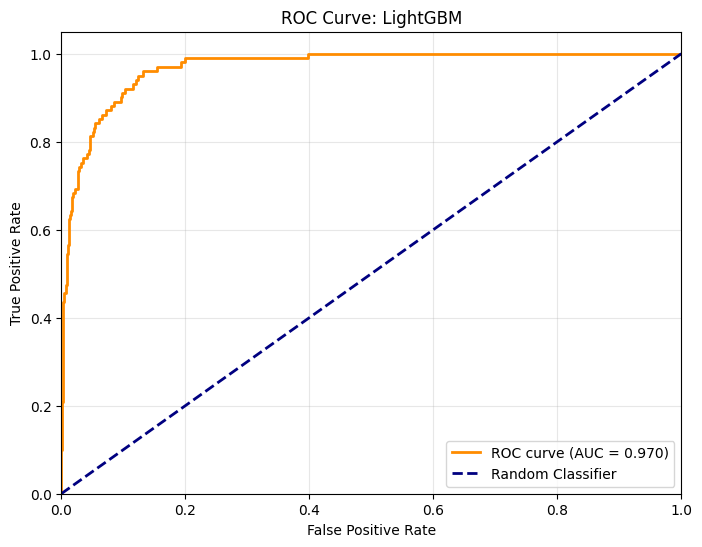

In [240]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_lgbm:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: LightGBM')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [243]:
# calculate precision-recall curve components (NOTE: _pr notation)
precision_lgbm, recall_lgbm, thresholds_lgmb_pr = precision_recall_curve(y_test, y_probs_lgbm)

In [245]:
# generate PR_AUC score
pr_auc_lgbm = auc(recall_lgbm, precision_lgbm)

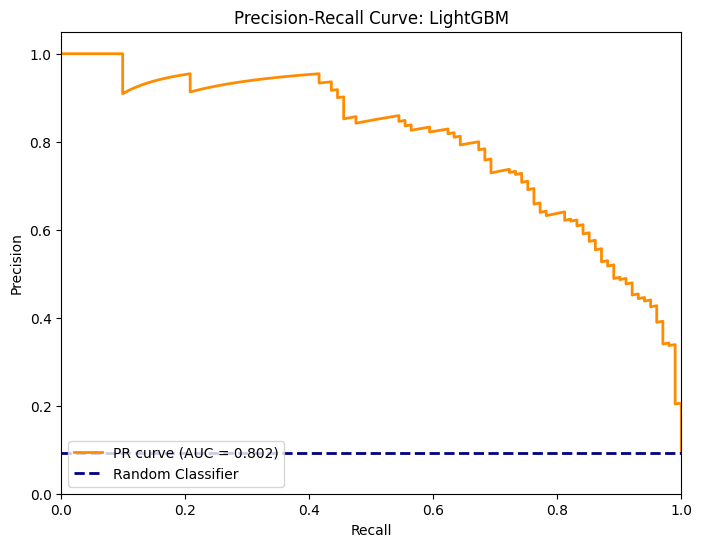

In [247]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_lgbm, precision_lgbm, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_lgbm:.3f})')
plt.axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: LightGBM')
plt.legend(loc="lower left")

## XGBoost

In [250]:
# define balance of positive and negative classes
imbalance_ratio = (y_train==0).sum() / (y_train==1).sum()
imbalance_ratio

9.686419753086419

In [252]:
# active native balancing
xgb = XGBClassifier(scale_pos_weight=imbalance_ratio, verbosity=0, random_state=42,)

# train model
xgb.fit(X_train, y_train)

# make predictions on test data
y_pred_xgb = xgb.predict(X_test)

print('XGBOOST')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred_xgb))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_xgb))

XGBOOST
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       981
           1       0.74      0.68      0.71       101

    accuracy                           0.95      1082
   macro avg       0.85      0.83      0.84      1082
weighted avg       0.95      0.95      0.95      1082

CONFUSION MATRIX:
[[957  24]
 [ 32  69]]


In [254]:
# generate probability predictions
y_probs_xgb = xgb.predict_proba(X_test)[:, 1]

In [256]:
# calculate ROC curve components
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)

In [258]:
# generate AUC score
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)

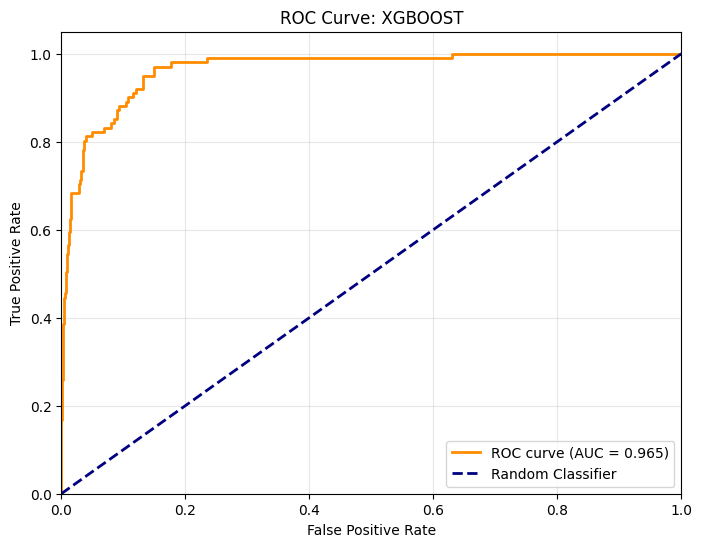

In [260]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_xgb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: XGBOOST')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [263]:
# calculate precision-recall curve components (NOTE: _pr notation)
precision_xgb, recall_xgb, thresholds_lgmb_pr = precision_recall_curve(y_test, y_probs_xgb)

In [265]:
# generate PR_AUC score
pr_auc_xgb = auc(recall_xgb, precision_xgb)

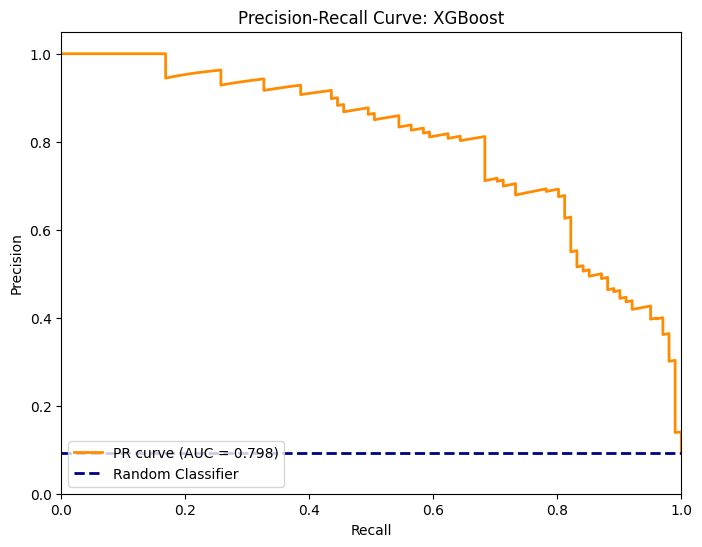

In [267]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_xgb, precision_xgb, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_xgb:.3f})')
plt.axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: XGBoost')
plt.legend(loc="lower left")

## CatBoost

In [271]:
# active native balancing
cb = CatBoostClassifier(
        iterations=1000,               # number of boosting iterations
        learning_rate=0.03,            # learning rate
        depth=6,                       # depth of trees
        loss_function='Logloss',       # for binary classification
        eval_metric='AUC',             # useful for imbalanced data
        random_seed=42,
        verbose=0,                     # print progress every 100 iterations
        auto_class_weights='Balanced'  # handles class imbalance
)

# train model
cb.fit(X_train, y_train)

# make predictions on test data
y_pred_cb = cb.predict(X_test)

print('CATBOOST')
print('CLASSIFICATION REPORT:')
print(classification_report(y_test, y_pred_cb))
print('CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_cb))

CATBOOST
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       981
           1       0.68      0.75      0.72       101

    accuracy                           0.94      1082
   macro avg       0.83      0.86      0.84      1082
weighted avg       0.95      0.94      0.95      1082

CONFUSION MATRIX:
[[946  35]
 [ 25  76]]


In [272]:
# generate probability predictions
y_probs_cb = cb.predict_proba(X_test)[:, 1]

In [273]:
# calculate ROC curve components
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, y_probs_cb)

In [274]:
# generate AUC score
roc_auc_cb = roc_auc_score(y_test, y_probs_cb)

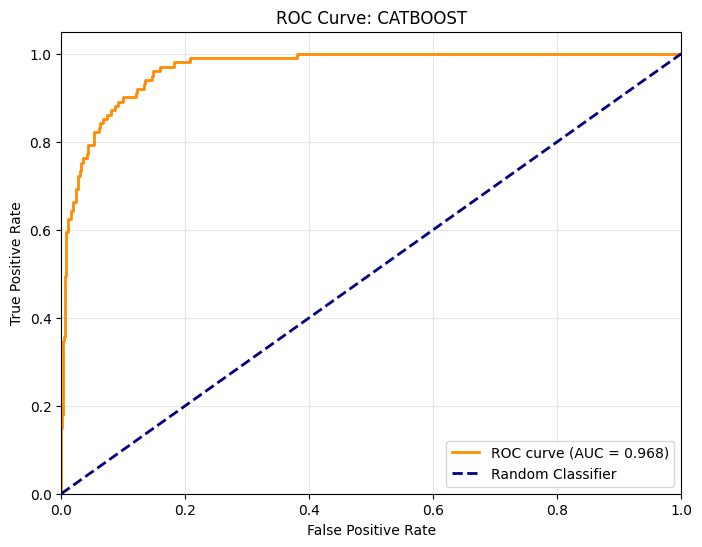

In [275]:
# visualize the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cb, tpr_cb, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_cb:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CATBOOST')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [282]:
# calculate precision-recall curve components (NOTE: _pr notation)
precision_cb, recall_cb, thresholds_lgmb_pr = precision_recall_curve(y_test, y_probs_cb)

In [284]:
# generate PR_AUC score
pr_auc_cb = auc(recall_cb, precision_cb)

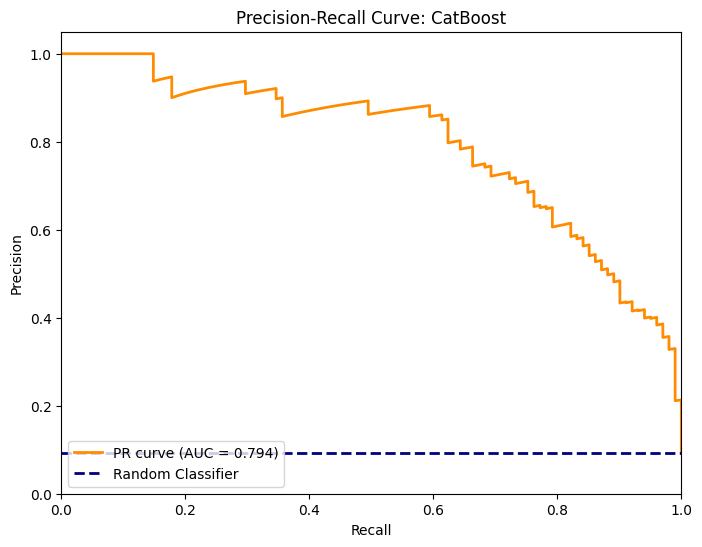

In [286]:
# visualize precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_cb, precision_cb, color='darkorange', lw=2, label=f'PR curve (AUC = {pr_auc_cb:.3f})')
plt.axhline(y=y_test.mean(), color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve: CatBoost')
plt.legend(loc="lower left")

## Compare all the models

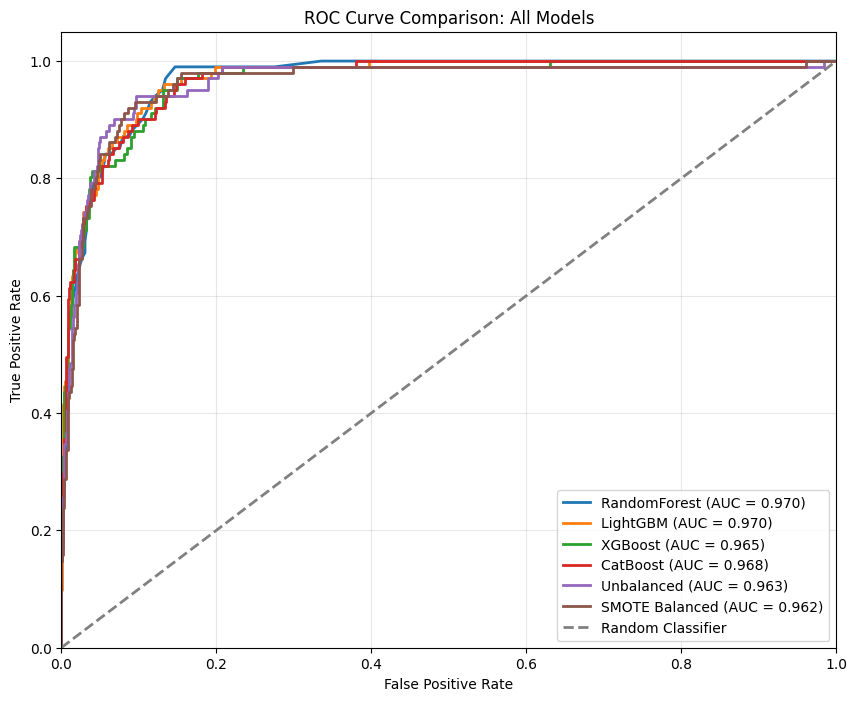

In [289]:
# visualize all ROC curves on one plot
plt.figure(figsize=(10, 8))

# Plot all model curves
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'RandomForest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_lgbm, tpr_lgbm, lw=2, label=f'LightGBM (AUC = {roc_auc_lgbm:.3f})')
plt.plot(fpr_xgb, tpr_xgb, lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot(fpr_cb, tpr_cb, lw=2, label=f'CatBoost (AUC = {roc_auc_cb:.3f})')
plt.plot(fpr_unbalanced, tpr_unbalanced, lw=2, label=f'Unbalanced (AUC = {roc_auc_unbalanced:.3f})')
plt.plot(fpr_smote, tpr_smote, lw=2, label=f'SMOTE Balanced (AUC = {roc_auc_smote:.3f})')

# Plot random classifier baseline
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: All Models')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

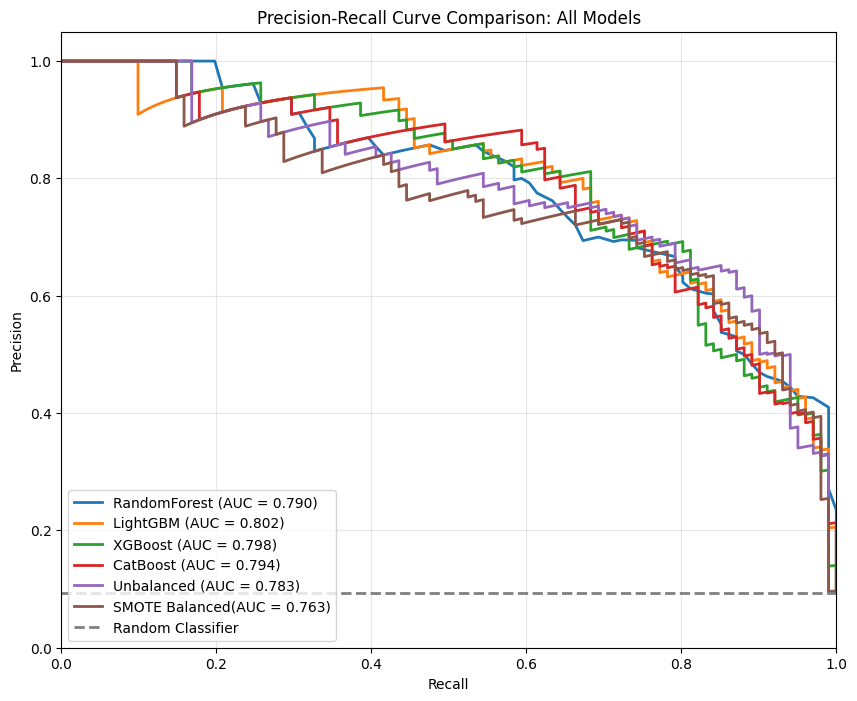

In [291]:
# visualize all precision-recall curves on one plot
plt.figure(figsize=(10, 8))

plt.plot(recall_rf, precision_rf, lw=2, label=f'RandomForest (AUC = {pr_auc_rf:.3f})')
plt.plot(recall_lgbm, precision_lgbm, lw=2, label=f'LightGBM (AUC = {pr_auc_lgbm:.3f})')
plt.plot(recall_xgb, precision_xgb, lw=2, label=f'XGBoost (AUC = {pr_auc_xgb:.3f})')
plt.plot(recall_cb, precision_cb, lw=2, label=f'CatBoost (AUC = {pr_auc_cb:.3f})')
plt.plot(recall_unbalanced, precision_unbalanced, lw=2, 
         label=f'Unbalanced (AUC = {pr_auc_unbalanced:.3f})')
plt.plot(recall_smote, precision_smote, lw=2, 
         label=f'SMOTE Balanced(AUC = {pr_auc_smote:.3f})')

# Random Classifier baseline
plt.axhline(y=y_test.mean(), color='gray', lw=2, linestyle='--', 
            label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison: All Models')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)
plt.show()

# Feature Importances

## Logistic regression models

- coeff > 0 : increase in predictor variable increases log odds of positive class
- coeff < 0 : increase in predictor variable decreases log odds of positive class

features are standardized, so magnitudes can be compared directly.

In [293]:
lr_unbalanced_coefficients = lr_unbalanced.coef_[0]
lr_unbalanced_odds_ratios = np.exp(lr_unbalanced_coefficients)
lr_unbalanced_feature_importances = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': lr_unbalanced_coefficients,
    'Odds Ratio': lr_unbalanced_odds_ratios
}).sort_values(by='Coefficient', ascending=False)
lr_unbalanced_feature_importances.head(10)

,Feature,Coefficient,Odds Ratio
9,claim_duration_std_ip,1.112466,3.041850
29,total_reimbursement_ip,1.067330,2.907606
13,covered_percentage_mean_ip,1.062304,2.893030
12,total_claim_amount_ip,0.925591,2.523359
7,inpatient_duration_std_ip,0.680895,1.975645
0,deductible_mean_ip,0.609219,1.838995
4,age_mean_ip,0.593317,1.809983
53,claim_freq_op,0.576077,1.779045
46,claim_count_op,0.576077,1.779045
24,num_state_ip,0.573653,1.774739


In [295]:
lr_smote_coefficients = lr_smote.coef_[0]
lr_smote_odds_ratios = np.exp(lr_smote_coefficients)
lr_smote_feature_importances = pd.DataFrame({
    'Feature': X_lr.columns,
    'Coefficient': lr_smote_coefficients,
    'Odds Ratio': lr_smote_odds_ratios
}).sort_values(by='Coefficient', ascending=False)
lr_smote_feature_importances.head(10)

,Feature,Coefficient,Odds Ratio
13,covered_percentage_mean_ip,2.467211,11.789515
0,deductible_mean_ip,1.829621,6.231523
24,num_state_ip,1.787594,5.975057
9,claim_duration_std_ip,1.665647,5.289093
40,covered_percentage_mean_op,1.642353,5.167314
29,total_reimbursement_ip,1.578167,4.846066
12,total_claim_amount_ip,1.417501,4.126796
53,claim_freq_op,0.730467,2.076051
46,claim_count_op,0.730467,2.076051
18,number_chronic_conditions_max_ip,0.566964,1.762907


In [301]:
# tuned_unbalanced_coefficients = tuned_unbalanced.estimator_.coef_[0]
# tuned_unbalanced_odds_ratios = np.exp(tuned_unbalanced_coefficients)

# tuned_unbalanced_feature_importances = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Coefficient': tuned_unbalanced_coefficients,
#     'Odds Ratio': tuned_unbalanced_odds_ratios
# }).sort_values(by='Coefficient', ascending=False)
# tuned_unbalanced_feature_importances.head(10)

## Black box models

In [309]:
# get feature importances (Gini importance by default)
rf_importances = rf.feature_importances_

# get feature names 
rf_feature_names = X_train.columns 

# Create dataframe
rf_importances_df = pd.DataFrame({
    'Feature': rf_feature_names,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

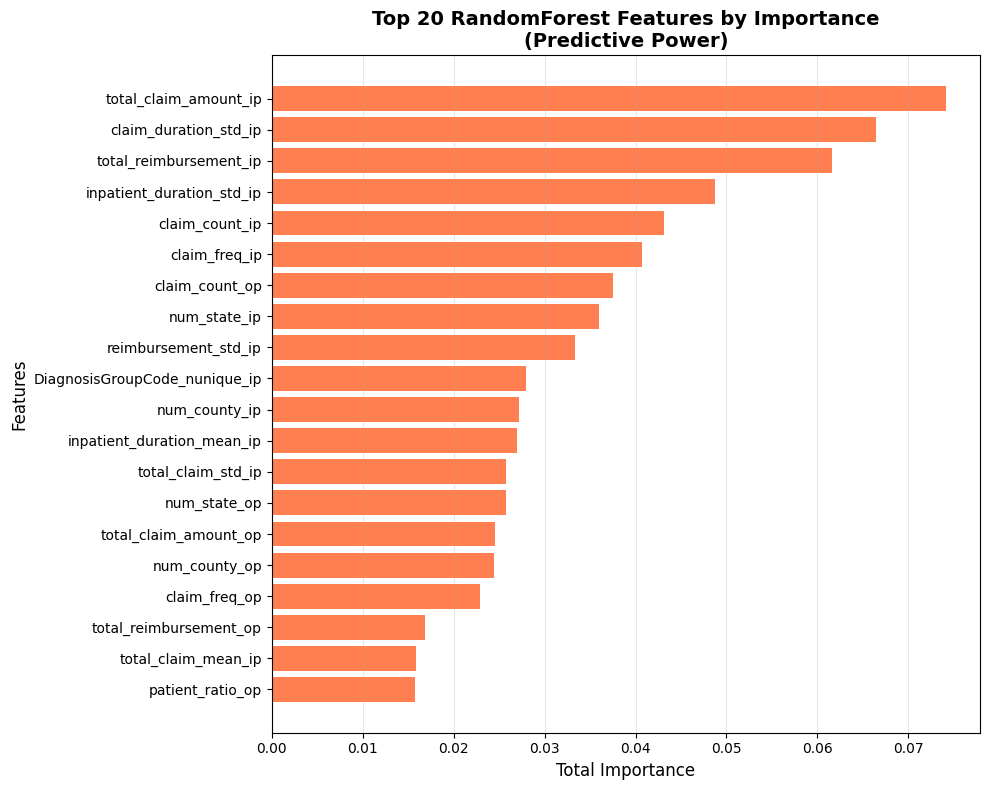

In [311]:
# create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

rf_top_gain = rf_importances_df.nlargest(20, 'Importance').sort_values('Importance')
ax.barh(rf_top_gain['Feature'], rf_top_gain['Importance'], color='coral')
ax.set_xlabel('Total Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Top 20 RandomForest Features by Importance\n(Predictive Power)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [315]:
# get feature importances based on gain
lgbm_importances = lgbm.booster_.feature_importance(importance_type='gain')

# get feature names
lgbm_feature_names = lgbm.booster_.feature_name()

# create dataframe 
lgbm_importances_df = pd.DataFrame({
    'Feature': lgbm_feature_names,
    'Gain_Importance': lgbm_importances
}).sort_values('Gain_Importance', ascending=False)

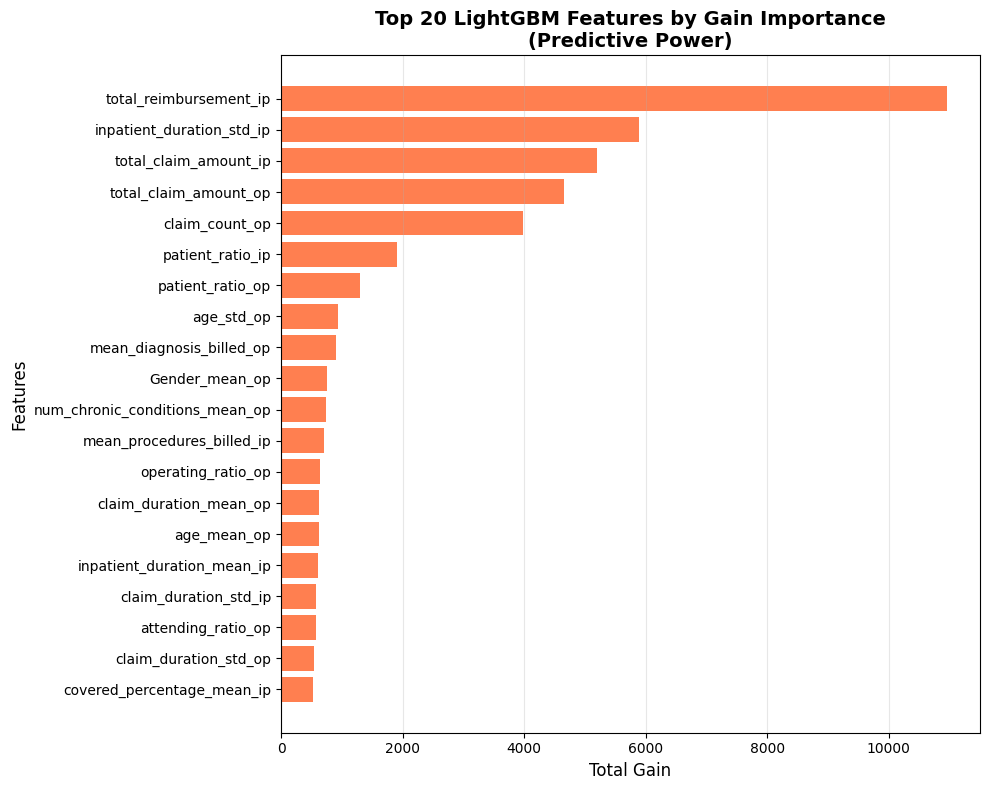

In [317]:
 # create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lgbm_top_gain = lgbm_importances_df.nlargest(20, 'Gain_Importance').sort_values('Gain_Importance')
ax.barh(lgbm_top_gain['Feature'], lgbm_top_gain['Gain_Importance'], color='coral')
ax.set_xlabel('Total Gain', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Top 20 LightGBM Features by Gain Importance\n(Predictive Power)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [320]:
# get feature importances based on gain
xgb_importances = xgb.get_booster().get_score(importance_type='gain')

# get feature names and importances
xgb_feature_names = list(xgb_importances.keys())
xgb_importance_values = list(xgb_importances.values())

# create dataframe 
xgb_importances_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Gain_Importance': xgb_importance_values
}).sort_values('Gain_Importance', ascending=False)

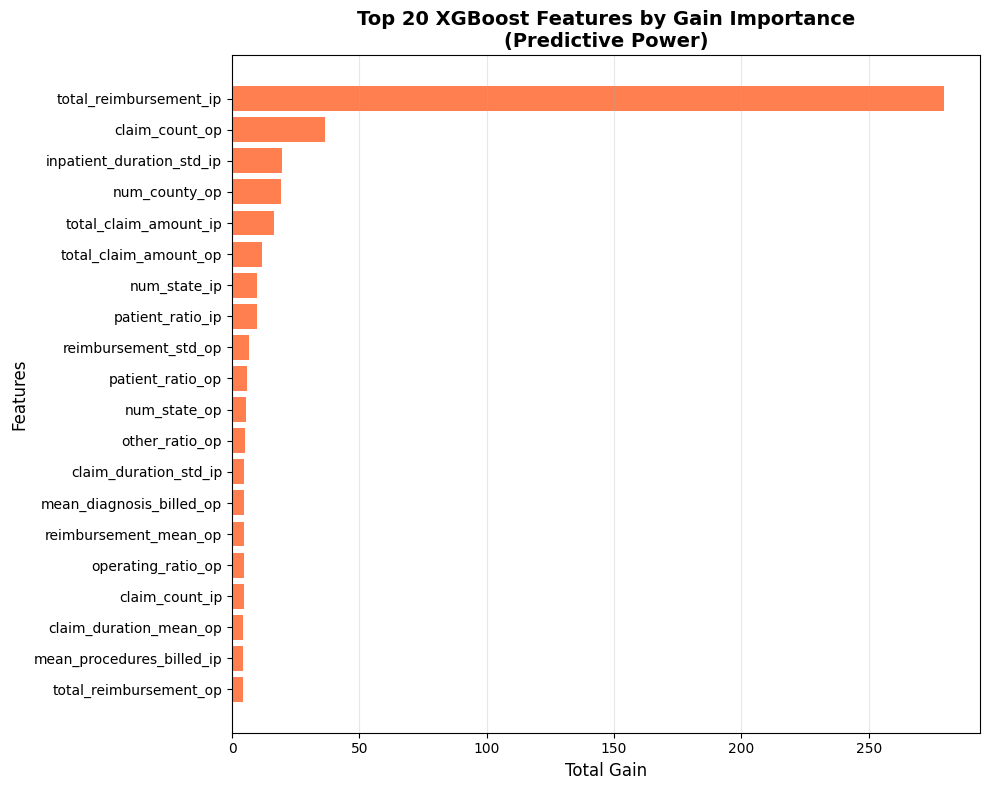

In [322]:
# create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

xgb_top_gain = xgb_importances_df.nlargest(20, 'Gain_Importance').sort_values('Gain_Importance')
ax.barh(xgb_top_gain['Feature'], xgb_top_gain['Gain_Importance'], color='coral')
ax.set_xlabel('Total Gain', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Top 20 XGBoost Features by Gain Importance\n(Predictive Power)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [326]:
# get feature importances based on gain
cb_importances = cb.get_feature_importance()

# get feature names
cb_feature_names = cb.feature_names_

# create dataframe 
cb_importances_df = pd.DataFrame({
    'Feature': cb_feature_names,
    'Gain_Importance': cb_importances
}).sort_values('Gain_Importance', ascending=False)

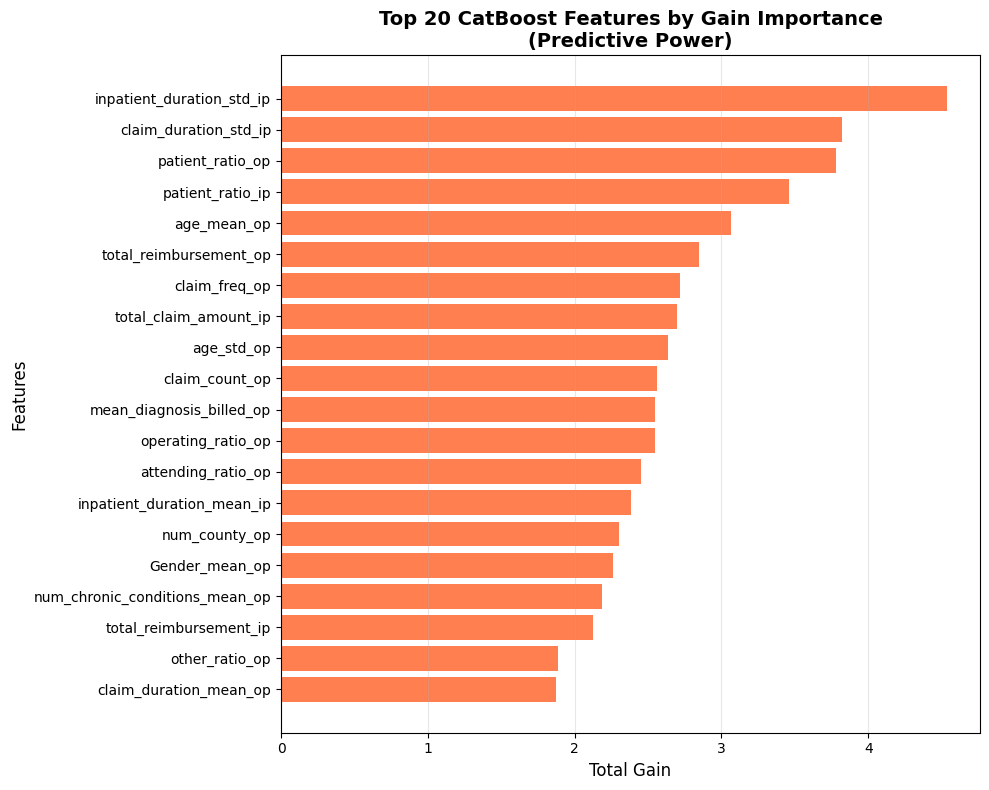

In [328]:
# create visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
cb_top_gain = cb_importances_df.nlargest(20, 'Gain_Importance').sort_values('Gain_Importance')
ax.barh(cb_top_gain['Feature'], cb_top_gain['Gain_Importance'], color='coral')
ax.set_xlabel('Total Gain', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Top 20 CatBoost Features by Gain Importance\n(Predictive Power)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# SHAP values

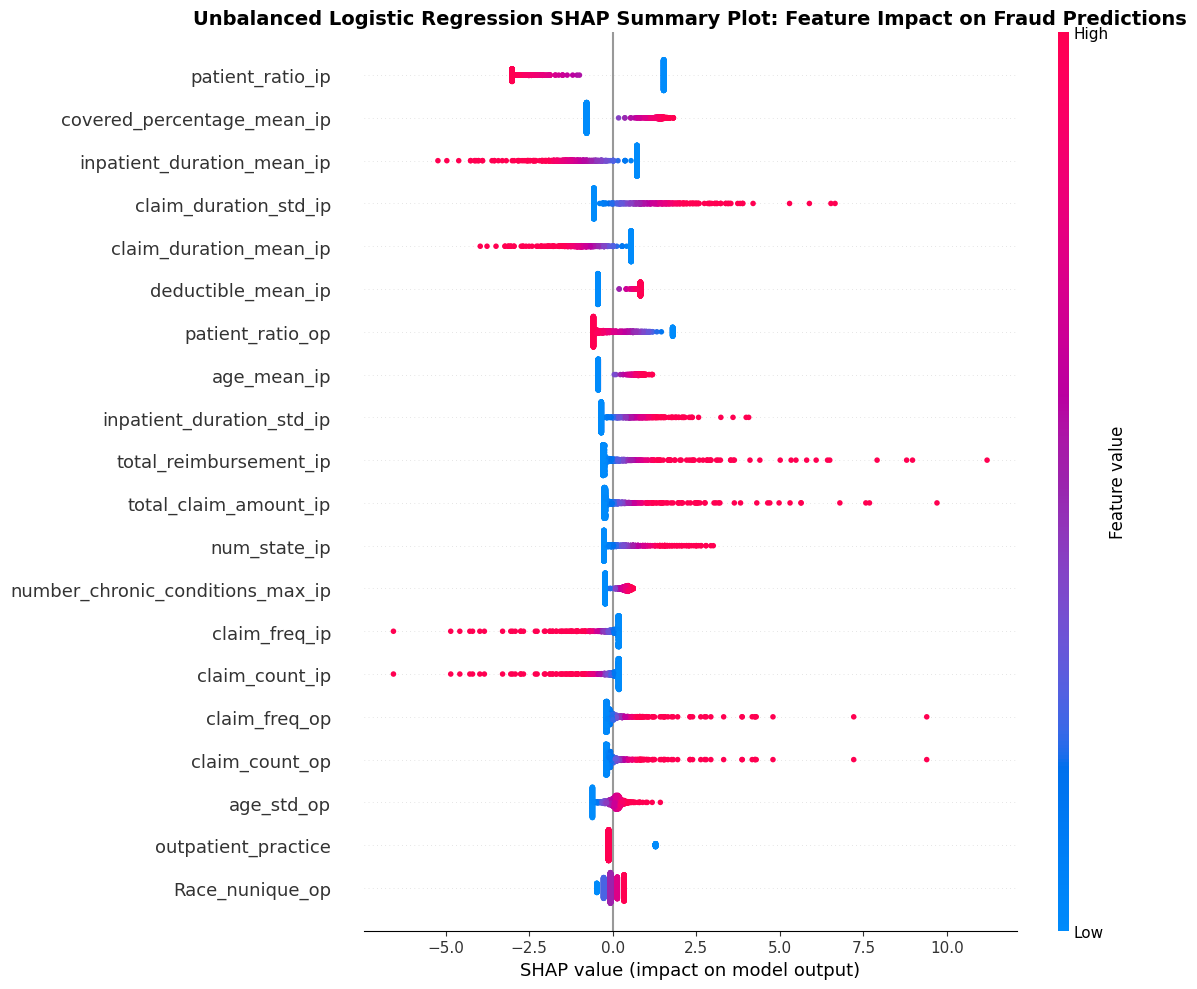

In [334]:
# create SHAP explainer
lr_unbalanced_explainer = shap.LinearExplainer(lr_unbalanced, X_train_lr)
lr_unbalanced_shap_values = lr_unbalanced_explainer(X_test_lr)

shap.summary_plot(lr_unbalanced_shap_values, X_test_lr, feature_names=X_test.columns, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("Unbalanced Logistic Regression SHAP Summary Plot: Feature Impact on Fraud Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

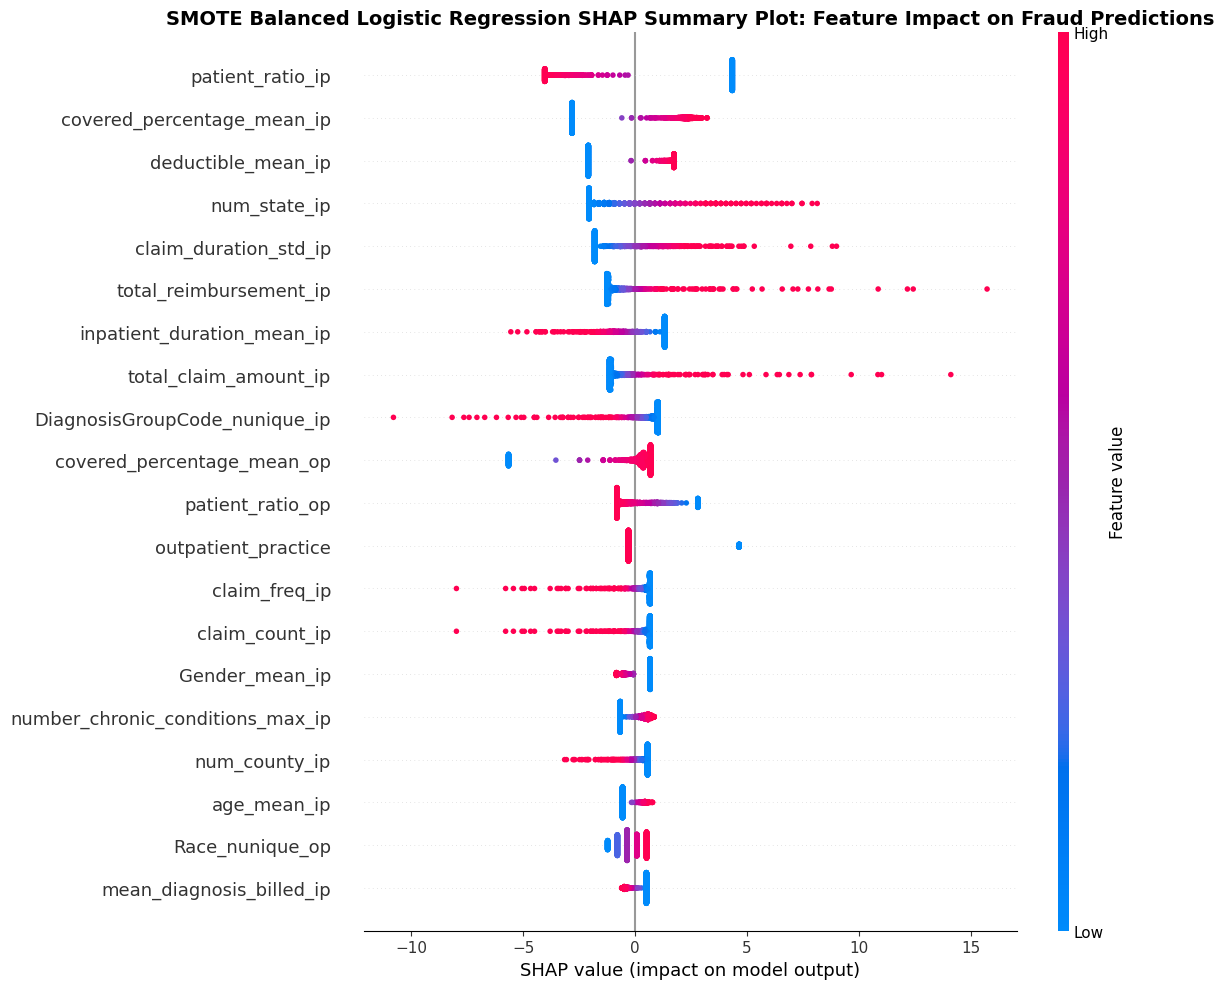

In [335]:
# create SHAP explainer
lr_smote_explainer = shap.LinearExplainer(lr_smote, X_train_smote)
lr_smote_shap_values = lr_smote_explainer(X_test_lr)

shap.summary_plot(lr_smote_shap_values, X_test_lr, feature_names=X_test.columns, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("SMOTE Balanced Logistic Regression SHAP Summary Plot: Feature Impact on Fraud Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

In [339]:
# # Create SHAP explainer for the tuned model
# # Extract the underlying estimator from the TunedThresholdClassifierCV wrapper
# tuned_lr_explainer = shap.LinearExplainer(tuned_unbalanced.estimator_, X_train_lr)
# tuned_lr_shap_values = tuned_lr_explainer(X_test_lr)

# # Plot
# shap.summary_plot(tuned_lr_shap_values, X_test_lr, feature_names=X_test.columns, show=False)
# plt.gcf().set_size_inches(12, 10) 
# plt.title("Tuned Unbalanced Logistic Regression SHAP Summary Plot: Feature Impact on Fraud Predictions", 
#           fontsize=14, fontweight='bold')
# plt.tight_layout()
# plt.show()

**Note:** RandomForest outputs probabilities for both classes, so have to select one. LightGBM outputs the log-odds for the positive class. 

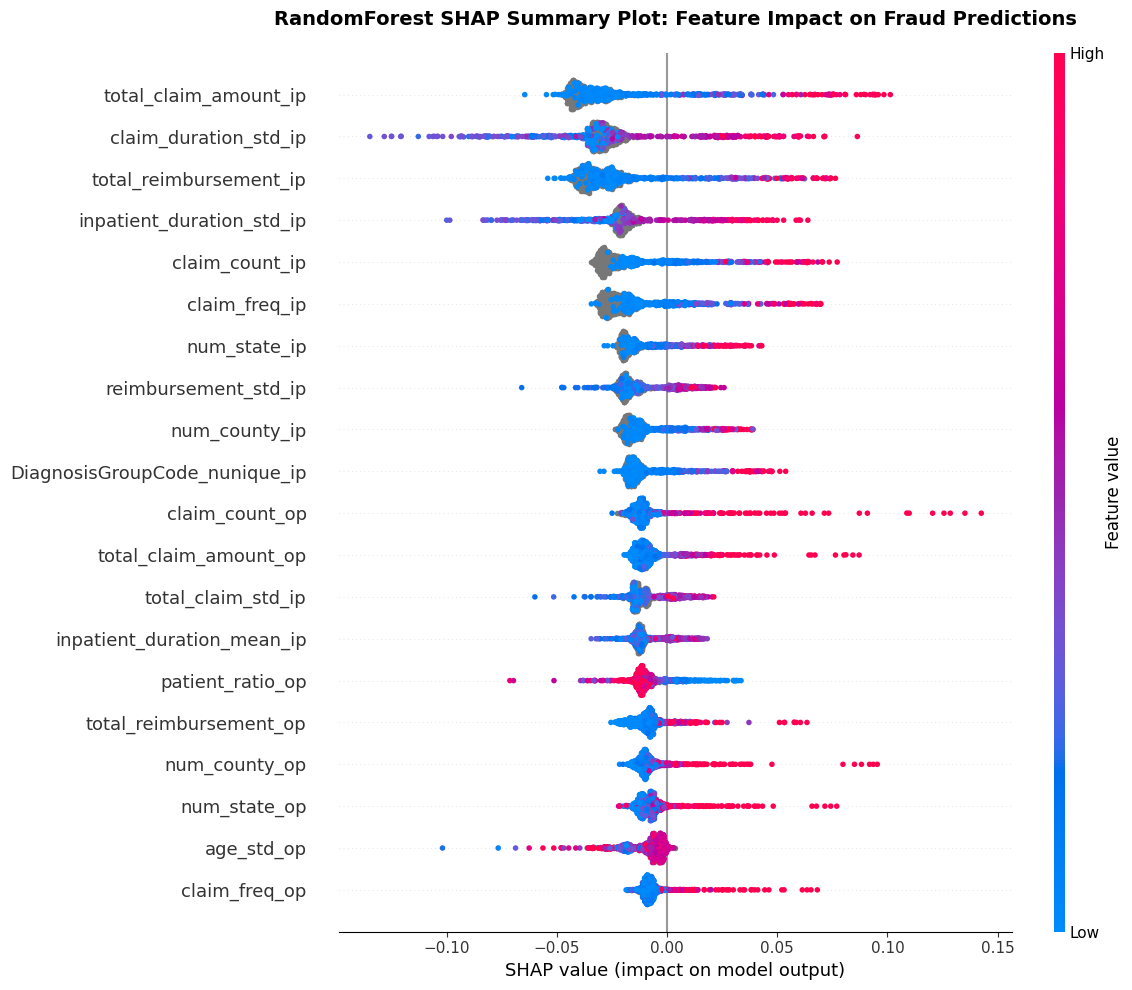

In [341]:
# create SHAP explainer
rf_explainer = shap.TreeExplainer(rf)
rf_shap_values = rf_explainer(X_test)

# For binary classification, select class 1 (fraud class)
shap.summary_plot(rf_shap_values[:, :, 1], X_test, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("RandomForest SHAP Summary Plot: Feature Impact on Fraud Predictions", 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

In [342]:
# shap.waterfall_plot(rf_shap_values[0, :, 1])

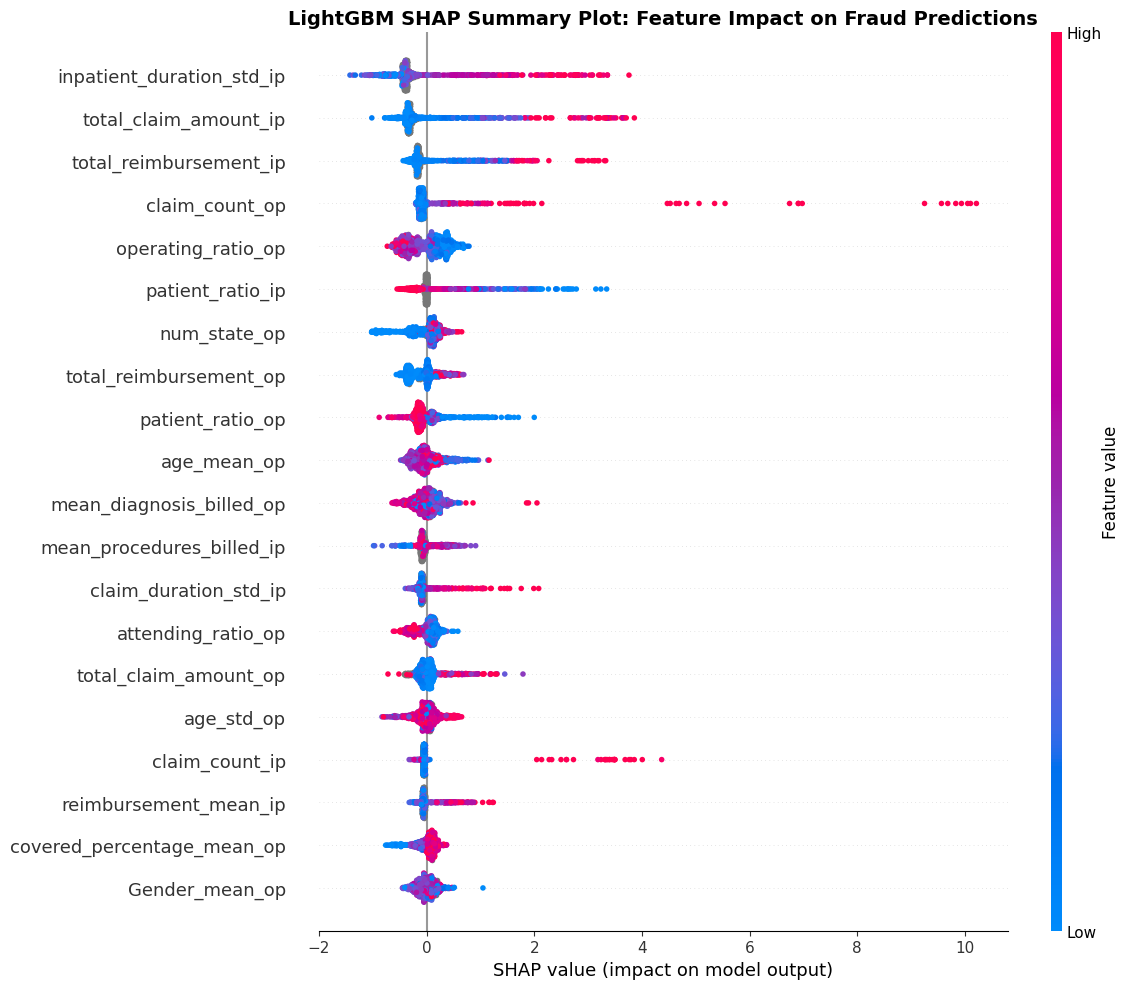

In [344]:
# create SHAP explainer
lgbm_explainer = shap.TreeExplainer(lgbm)
lgbm_shap_values = lgbm_explainer(X_test)

shap.summary_plot(lgbm_shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("LightGBM SHAP Summary Plot: Feature Impact on Fraud Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

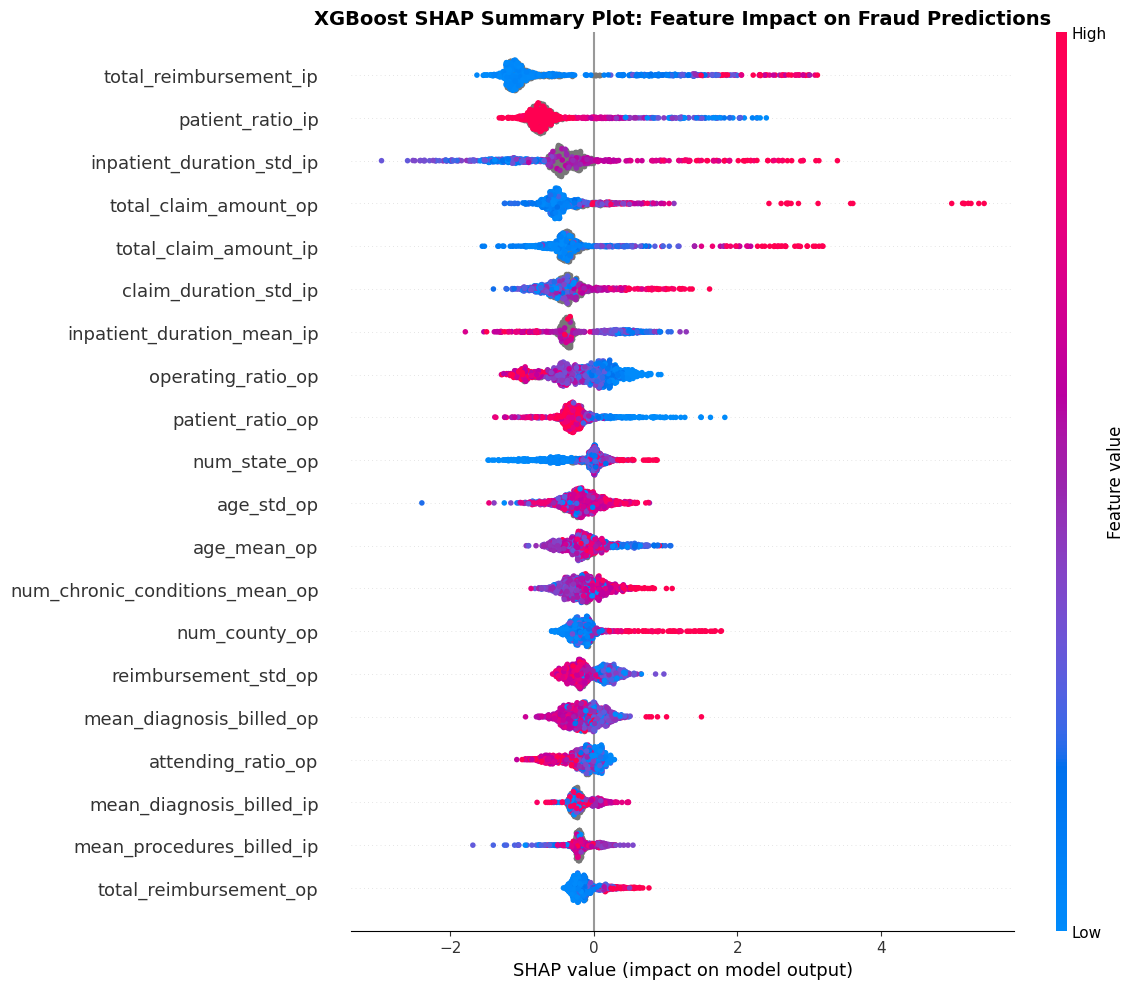

In [345]:
# create SHAP explainer
xgb_explainer = shap.TreeExplainer(xgb)
xgb_shap_values = xgb_explainer(X_test)

shap.summary_plot(xgb_shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("XGBoost SHAP Summary Plot: Feature Impact on Fraud Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

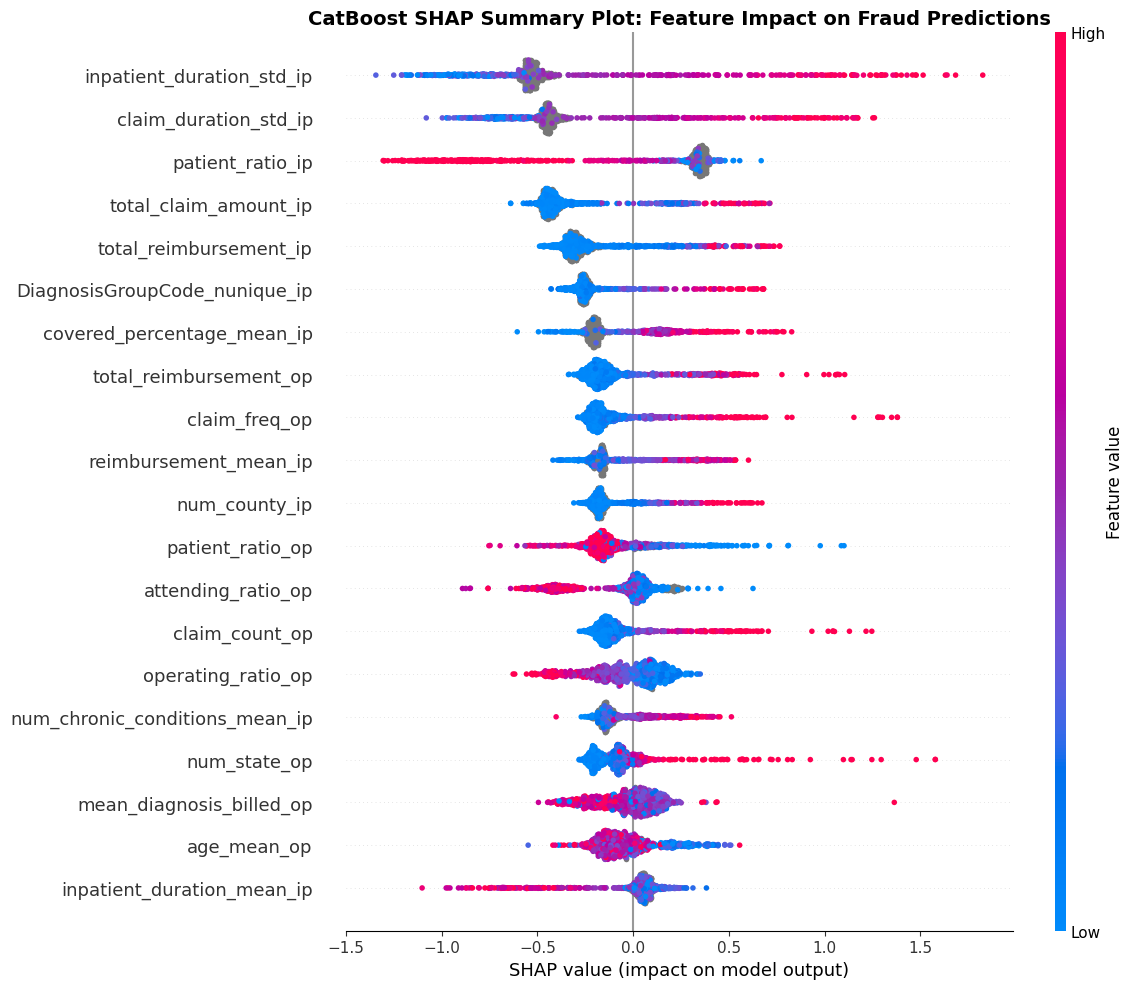

In [350]:
# create SHAP explainer
cb_explainer = shap.TreeExplainer(cb)
cb_shap_values = cb_explainer(X_test)

shap.summary_plot(cb_shap_values, X_test, show=False)
plt.gcf().set_size_inches(12, 10) 
plt.title("CatBoost SHAP Summary Plot: Feature Impact on Fraud Predictions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show() 

In [354]:
# Confusion matrix analysis
print('UNBALANCED LOGISTIC REGRESSION CONFUSION MATRIX:')
print(confusion_matrix(y_test_lr, y_pred_unbalanced))
print()
print('SMOTE BALANCED LOGISTIC REGRESSION CONFUSION MATRIX:')
print(confusion_matrix(y_test_lr, y_pred_smote))
print()
print('RANDOMFOREST CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_rf))
print()

print('LIGHTGBM CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_lgbm))
print()

print('XGBOOST CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_xgb))
print()
print('CATBOOST CONFUSION MATRIX:')
print(confusion_matrix(y_test, y_pred_cb))

UNBALANCED LOGISTIC REGRESSION CONFUSION MATRIX:
[[906  75]
 [ 97   4]]

SMOTE BALANCED LOGISTIC REGRESSION CONFUSION MATRIX:
[[799 182]
 [ 83  18]]

RANDOMFOREST CONFUSION MATRIX:
[[972   9]
 [ 48  53]]

LIGHTGBM CONFUSION MATRIX:
[[949  32]
 [ 25  76]]

XGBOOST CONFUSION MATRIX:
[[957  24]
 [ 32  69]]

CATBOOST CONFUSION MATRIX:
[[946  35]
 [ 25  76]]


In [356]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_cb).ravel().tolist()
tn, fp, fn, tp

(946, 35, 25, 76)

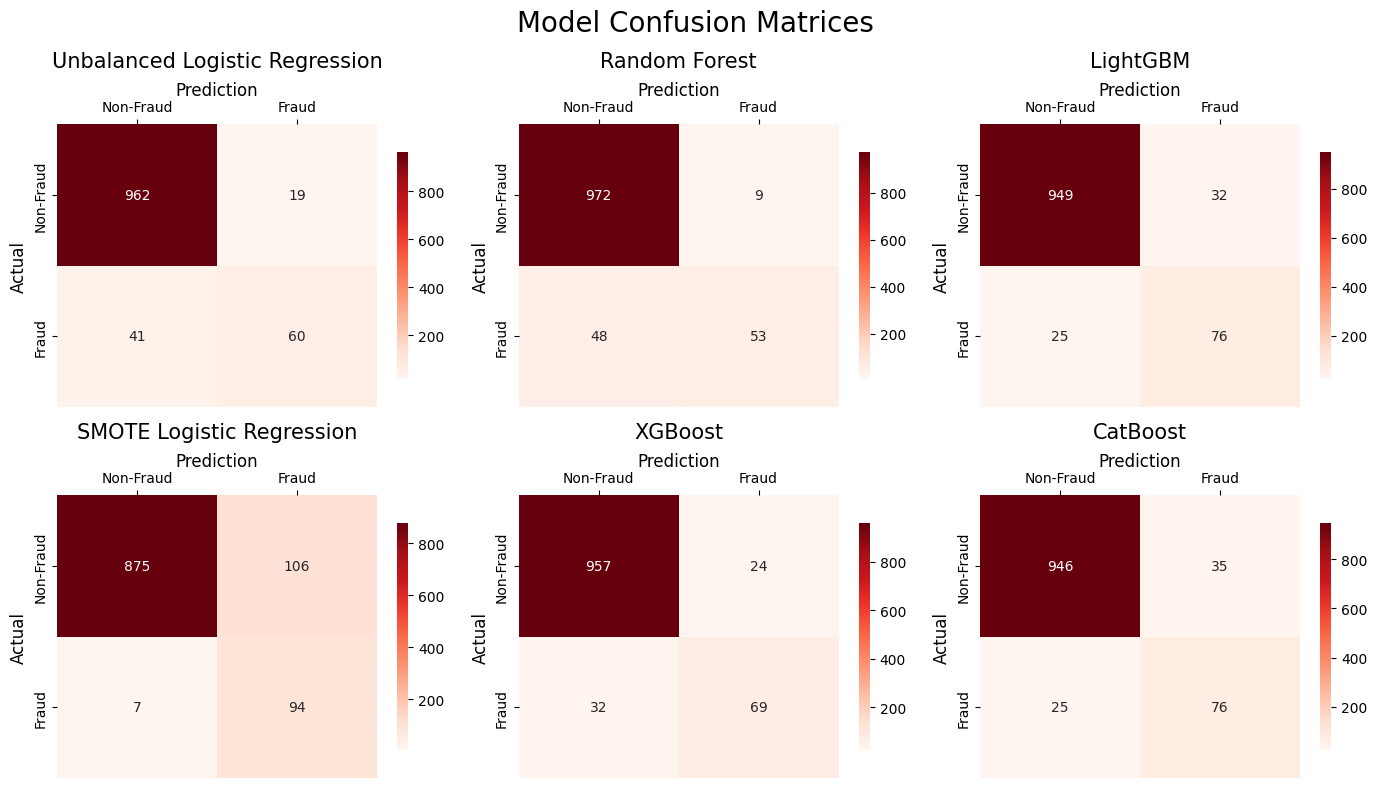

In [359]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Model Confusion Matrices', fontsize=20, y=0.98)

# Flatten axes array for easier iteration
axes = axes.flatten()

# list of model predictions
predictions = [
    ('Unbalanced Logistic Regression', y_pred_unbalanced),
    ('Random Forest', y_pred_rf),
    ('LightGBM', y_pred_lgbm), 
    ('SMOTE Logistic Regression', y_pred_smote),
    ('XGBoost', y_pred_xgb),  
    ('CatBoost', y_pred_cb)   
]

# Create heatmaps for each subplot
for idx, (model_name, y_pred) in enumerate(predictions):
    ax = axes[idx]
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create heatmap
    sns.heatmap(cm, 
                annot=True,
                fmt='g',
                cmap='Reds',
                xticklabels=['Non-Fraud', 'Fraud'],
                yticklabels=['Non-Fraud', 'Fraud'],
                ax=ax,
                cbar_kws={'shrink': 0.8})
    
    # Set labels
    ax.set_title(f'{model_name}', fontsize=15, pad=10)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Prediction', fontsize=12)
    
    # Move x-axis to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

# Adjust layout
plt.tight_layout()
plt.show()

### Reordering the squares:

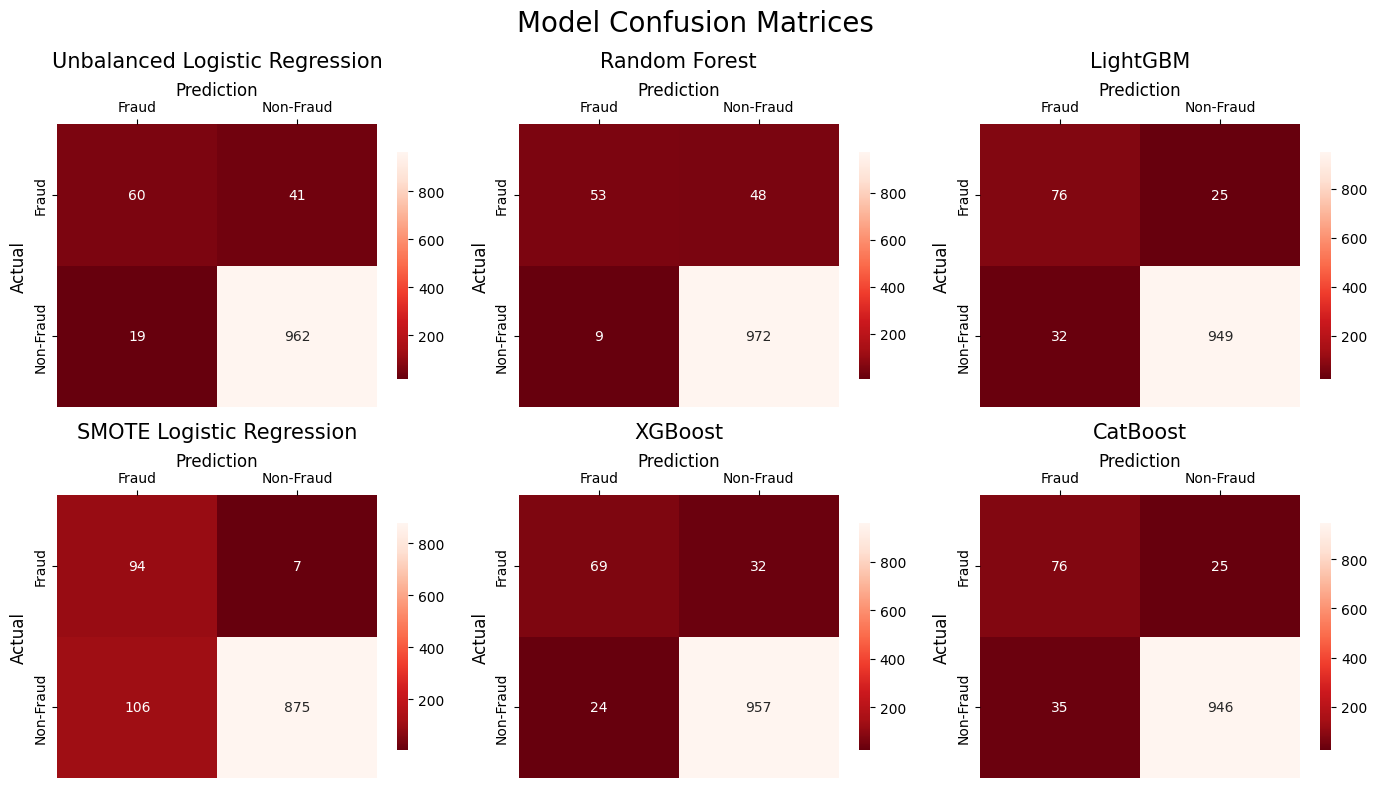

In [364]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
fig.suptitle('Model Confusion Matrices', fontsize=20, y=0.98)

# Flatten axes array for easier iteration
axes = axes.flatten()

# List of model predictions
predictions = [
    ('Unbalanced Logistic Regression', y_pred_unbalanced),
    ('Random Forest', y_pred_rf),
    ('LightGBM', y_pred_lgbm),
    ('SMOTE Logistic Regression', y_pred_smote),
    ('XGBoost', y_pred_xgb),
    ('CatBoost', y_pred_cb)
]

# Create heatmaps for each subplot
for idx, (model_name, y_pred) in enumerate(predictions):
    ax = axes[idx]
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # FLIP THE MATRIX - reverse both rows and columns
    cm_flipped = cm[::-1, ::-1]
    
    # Create heatmap
    sns.heatmap(cm_flipped,
                annot=True,
                fmt='g',
                cmap='Reds_r', # _r flips the color --> dark color to true positives
                xticklabels=['Fraud', 'Non-Fraud'],  # Reversed order
                yticklabels=['Fraud', 'Non-Fraud'],  # Reversed order
                ax=ax,
                cbar_kws={'shrink': 0.8})
    
    # Set labels
    ax.set_title(f'{model_name}', fontsize=15, pad=10)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_xlabel('Prediction', fontsize=12)
    
    # Move x-axis to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

# Adjust layout
plt.tight_layout()
plt.show()